# Israel Bus Arrival Times
This notebook was created by Yoav Elkayam as part of the Data Science workshop at the Israel Open University, Spring of 2024.

## Purpose and Goal definition

### Purpose

Public transportation is a vital part of urban mobility in Israel, and for soldiers, it serves as the primary means of transportation between bases, home, and other assignments. It's no secret that public transportation in Israel is not the most punctual type, and delays in bus schedules can cause significant inconvenience. These delays not only affect daily commutes but also the coordination of military activities, where punctuality is critical.

As a soldier who relies on public transport daily, I have personally experienced the challenges caused by unpredictable bus delays. This project aims to address these challenges by analyzing bus journey data and identifying patterns that cause delays, such as traffic conditions and peak travel times.

By building a reliable predictive model for bus delays, the project aims to improve the accuracy of bus arrival time estimates. This will not only benefit soldiers but also the general population, helping both transportation agencies and passengers better manage schedules and reduce inefficiencies.

Furthermore, understanding key factors like rush hour peaks, holiday schedules, and different route characteristics will provide insights to improve route planning and optimize bus networks for the benefit of all passengers.

### Goal

The primary goal of this project is to develop a predictive model that estimates bus arrival times, helping to reduce the uncertainty caused by delays in the public transportation system. Specifically, the project aims to:

1. Predict Bus Delays: Build a machine learning model capable of predicting delays for specific bus routes and stops based on historical data. This will help transportation agencies and passengers, including soldiers, better plan for travel, reducing frustration and improving overall efficiency.

2. Analyze Delay Patterns: Through Exploratory Data Analysis (EDA), identify important patterns and trends in the data, such as how delays vary during different times of the day (rush hours), on weekends versus weekdays, or during public holidays. This will provide insights into the factors that most influence delays.

3. Feature Engineering for Holidays and Peak Times: Introduce additional features, such as dummy variables for special days (e.g., holidays) and rush hour periods, to improve model accuracy. By capturing the impact of these factors, the model will better generalize to different days and times.

4. Model Evaluation and Comparison: Train and compare different machine learning models (e.g., Linear Regression, Random Forest, Gradient Boosting) to identify which model performs best in predicting bus delays. The evaluation will be based on key metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

5. Interpreting Model Predictions: Use explainability tools (such as SHAP) to understand how the model makes predictions. This will help identify the most important features driving the model's predictions, offering deeper insights into the main causes of bus delays.

By achieving these goals, the project will not only provide accurate predictions of bus arrival times but also contribute to understanding the key factors that cause delays. This can ultimately assist public transportation agencies in improving schedules and managing resources more effectively.



## Data Overview and Collection Process

The dataset we are investigating originates from the Israeli Ministry of Transportation (MOT), with data collected by "The Public Knowledge Workshop (Hasadna)." Hasadna is a civic technology organization that collects and processes data from various public entities, including transportation data, with the goal of increasing transparency and promoting public engagement.

The dataset is made available through their Open-Bus Stride API, which provides detailed information on bus movements across Israel. This enriched dataset merges two key types of information:
1. **Planned Schedule Data (GTFS)**: This dataset includes the planned schedules of bus routes, stops, and estimated arrival times, as specified by the transportation companies. It provides the theoretical framework of how buses are expected to run.
2. **Real-Time Bus Data**: This dataset captures the actual movement of buses in real time, based on GPS coordinates and other sensors installed on the buses. It includes information on when buses arrive at or pass each stop along their routes.

### Data Enrichment Process
The enrichment process that combines these two datasets is critical for providing a complete picture of how buses operate in practice. This process links the planned schedules with real-time data, allowing us to compare how closely buses follow their schedules. For example, we can observe when and where delays occur by comparing the expected arrival time from GTFS with the actual arrival time from the real-time data.

The enriched dataset offers additional insights by including calculated fields such as the nearest bus stop relative to the bus’s real-time location. Although this information is already part of the enriched data, we recalculate certain aspects—such as determining the closest bus stop—within this notebook to improve accuracy in the analysis.

### Purpose of Data Decomposition
In the first part of this notebook, we will break down the enriched data into its two components: the scheduled bus data and the real-time data. By doing so, we can reconstruct the bus routes, mapping out the points that represent each stop along the journey. This process will help us calculate the actual arrival times at each stop, which becomes the target variable for the predictive model we aim to build.

The decomposition of the data is necessary because the data is not provided in a format that allows direct use for this type of analysis. Furthermore, by recalculating specific features—such as determining the nearest bus stop location—we enhance the precision of the dataset, which is critical for developing accurate models.

### Time Frame and Data Selection
For this analysis, we will focus on data from **January 2023 to October 2023**. This period was chosen to avoid complications caused by external disruptions, such as the GPS signal interferences that occurred during the Israel–Hamas war. These disruptions affected the accuracy of location data, and by excluding periods of GPS disruption, we can ensure that our analysis is based on reliable data.

By focusing on this timeframe, we aim to capture a representative sample of bus operations under normal conditions, including peak travel times, holidays, and regular weekdays. This will allow us to model and predict bus delays under typical operational circumstances.


## Key terms Dictionary

| Term          | Definition                                                   |
|---------------|--------------------------------------------------------------|
| SIRI |  Service Interface for Real Time Information. Columns that start with "siri_" has data from real time bus locations pings.|
| GTFS | General Transit Feed Specification. Columns that start with "gtfs_" has data from planned bus schedule |
| Journey | A trip a bus take from its starting station to its last station on a specific route. When a bus send its location information, its related to one journey. Each journey has many location records in the data. |
| Another Term  | Another definition goes here.                                |

# Import Dependencies


In [22]:
# Standard library imports
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import glob
import os
import queue
import random
import threading
import time
from datetime import datetime, timedelta
from io import StringIO

# Third-party imports
import folium
import importlib
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from scipy.spatial import KDTree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine

# Local/application-specific imports
import data_processing


In [23]:
importlib.reload(data_processing)

<module 'data_processing' from 'c:\\Users\\yoave\\Documents\\OpenU\\Data Science\\data-science-project\\data_processing.py'>

### Defining Data location based on current workspace

In [2]:
DATA_FOLDER = './2023_siri_data'

In [ ]:
DATA_FOLDER = './drive/MyDrive/2023_siri_data'

In [26]:
DATA_FOLDER = 'G:\\My Drive\\2023_siri_data'

### Defining Time Boundaries For processing

In [24]:
START_DATE = "2023-01-01"
END_DATE = "2023-04-01"

# Data Collection

Our data is sourced from the Open-Bus Stride ETL packages. These packages provide data in hourly intervals. The data includes information about bus locations, the nearest stop to each bus location, and correlations to the GTFS ride. This includes the date and time of scheduled arrival times, among other details.


## Downloading Data
Here we download all data from the API

In [ ]:
data_processing.download_files(2023, DATA_FOLDER)

## Keeping the data intact

We might have a missing file in the data folder.
This function checks for missing files based on the compressed files folder


In [ ]:
data_processing.extract_missing_csv(DATA_FOLDER)

## Data Processing and Segmentation

This cell is designed to efficiently manage and process large datasets by breaking them down into more manageable chunks, optimizing memory usage, and enhancing data accessibility. The process involves several key steps:

1. **Data Segmentation**: The script segments large CSV files into smaller Parquet files, each containing up to 10 million rows. This segmentation facilitates easier handling of large datasets, as Parquet files are more efficient in terms of storage and speed when accessing subsets of data.

2. **Type Conversion and Cleanup**: It converts data types for specific columns to ensure consistency and optimizes memory usage. For example, it converts certain columns to string, integer, and floating-point types as needed. Additionally, it processes date columns to ensure they are in the correct datetime format.

3. **Column Removal**: To streamline the dataset, the script removes columns that are not immediately necessary for analysis. This step reduces file size and simplifies the dataset, making it easier to work with. The columns to be removed are specified in the [`columns_to_drop`](command:_github.copilot.openSymbolFromReferences?%5B%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22path%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22X20sZmlsZQ%3D%3D%22%7D%2C%7B%22line%22%3A67%2C%22character%22%3A4%7D%5D "/Users/yoavelkayam/Documents/OpenU/סדנה במדעי הנתונים/data-science-project/project.ipynb") list.

4. **File Management**: The script includes functionality to manage files efficiently. It removes the original CSV files after processing them into Parquet format to free up storage space. It also handles the continuation of data processing from where it left off, by identifying the last processed file and its position, thus avoiding reprocessing of data.

5. **Data Deduplication**: Before appending new data to the dataset, it removes duplicate entries to ensure the uniqueness of records.

6. **Dynamic File Naming**: The output Parquet files are named dynamically based on their content, indicating the range of data they contain. This naming convention makes it easier to identify and access specific segments of data.

7. **Efficient Data Concatenation**: The script concatenates new data to an existing DataFrame until the specified row limit is reached. Once the limit is reached, the data is saved to a Parquet file, and the process continues with the remaining data.

This approach not only optimizes the processing of large datasets by reducing memory overhead but also organizes the data into a more accessible and efficient format, facilitating faster data retrieval and analysis.

In [15]:
data_processing.process_files(DATA_FOLDER)

Folder size before processing: 62948374055 bytes
Folder size after processing: 62948374055 bytes


# Data Examination

In this phase, we will focus on analyzing a single bus line, specifically line 68, which operates from Kiryat Ono terminal to Tel-Aviv central station. Our analysis will be limited to the first month of 2023.

Our primary goal is to identify instances of delays and subsequently investigate potential causes for these delays.

To facilitate this, we will prepare a DataFrame that consolidates all relevant data pertaining to this bus line.


In [24]:
def create_filtered_df(parquet_dir, line_refs, limit=0, offset=0):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')  
    parquet_files.sort(key=data_processing.extract_number)
        
    if limit > 0:
        parquet_files = parquet_files[offset:offset+limit]
    else:
        parquet_files = parquet_files[offset:]

    df = pd.DataFrame()
    
    counter = 0

    for file in parquet_files:
        # Read the Parquet file
        temp_df = pd.read_parquet(file, filters=[('siri_line_ref', 'in', line_refs)])
        temp = temp_df.astype({'gtfs_stop_lat': float, 'gtfs_stop_lon': float, 'lat': float, 'lon': float})
        df = pd.concat([df, temp_df])
        counter += 1

        if counter % 20 == 0:
            print(f'Processed {counter} files. Current file: {os.path.basename(file)}')

    return df

In [27]:
df = create_filtered_df(f'{DATA_FOLDER}/concatenated_data_parquet', ['987'], limit=16)

## Sorting and Formatting Data

In this step, we sort the dataframe `df` by 'siri_journey_ref' and 'recorded_at_time'. 

We then create two new dataframes:

- `df_bus_journey_stops`: This dataframe is created by selecting specific columns from `df_sorted` and dropping duplicates. It contains information about the bus journey stops.

- `df_locations`: This dataframe is created by excluding columns that start with 'gtfs' from `df_sorted`. It contains information about the bus locations from siri.


In [25]:
def process_dataframe(df):
    # Remove unnecessary sorting if not required later
    # Since you drop duplicates later, sorting might be redundant
    bus_journey_cols = [
        'id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_stop_order',
        'siri_operator_ref', 'siri_line_ref', 'gtfs_journey_ref', 'gtfs_start_time', 'gtfs_end_time',
        'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'gtfs_stop_city', 'gtfs_arrival_time',
        'gtfs_stop_sequence', 'gtfs_route_short_name', 'gtfs_route_direction', 'gtfs_route_mkt'
    ]

    # Select only necessary columns to reduce memory usage
    df_bus_journey_stops = df[bus_journey_cols].drop_duplicates()

    # Remove rows where 'gtfs_stop_lat' or 'gtfs_stop_lon' is NaN
    df_bus_journey_stops.dropna(subset=['gtfs_stop_lat', 'gtfs_stop_lon'], inplace=True)

    # Select columns not starting with 'gtfs'
    location_cols = df.columns[~df.columns.str.startswith('gtfs')]
    df_locations = df[location_cols]

    # Remove journeys where all locations have the same lat and lon
    journey_counts = df_locations.groupby('siri_journey_ref')[['lat', 'lon']].nunique()
    journeys_to_keep = journey_counts[(journey_counts['lat'] > 2) | (journey_counts['lon'] > 2)].index

    # Filter DataFrames based on 'journeys_to_keep'
    df_locations = df_locations[df_locations['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'].isin(journeys_to_keep)]

    # Drop duplicates with specific subset
    df_bus_journey_stops.drop_duplicates(
        subset=['gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'siri_journey_ref'],
        inplace=True
    )

    return df_bus_journey_stops, df_locations

In [28]:
df_bus_journey_stops, df_locations = process_dataframe(df)

## Calculating Distance and Speed

In this step, we define a function `calculate_distance_and_speed` to calculate the distance and speed for each journey.

- The `haversine` function calculates the distance between two points on the Earth's surface given their latitudes and longitudes.
- It then calculates the time difference between consecutive locations and uses this to calculate the speed.
- Any `NaN` values in the 'speed', 'distance', and 'time_diff' columns are replaced with 0.

Finally, we apply this function to our DataFrame `df_locations` using the `groupby` and `apply` methods, and reset the index.


In [26]:
@njit
def haversine_array(lat1, lon1, lat2, lon2):
    # Vectorized haversine formula with Numba
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return 6371 * c

def process_locations(df_locations):
    # Sort by journey reference and timestamp
    df_locations.sort_values(['siri_journey_ref', 'recorded_at_time'], inplace=True)
    df_locations.reset_index(drop=True, inplace=True)

    # Extract necessary columns as numpy arrays
    lat = df_locations['lat'].values
    lon = df_locations['lon'].values
    time = df_locations['recorded_at_time'].astype('int64').values / 1e9  # Convert to seconds
    journey_refs = df_locations['siri_journey_ref'].values

    n = len(df_locations)
    distances = np.zeros(n)  # Initialize with zeros instead of NaN
    time_diffs = np.zeros(n)
    speeds = np.zeros(n)

    # Create mask for valid calculations (consecutive points in same journey)
    valid_diff = journey_refs[1:] == journey_refs[:-1]

    # Calculate for valid pairs
    if np.any(valid_diff):  # Only proceed if there are valid pairs
        lat1 = lat[:-1][valid_diff]
        lon1 = lon[:-1][valid_diff]
        lat2 = lat[1:][valid_diff]
        lon2 = lon[1:][valid_diff]
        time_diff_valid = (time[1:] - time[:-1])[valid_diff] / 3600  # Convert to hours

        # Calculate distances and speeds
        distances_valid = haversine_array(lat1, lon1, lat2, lon2)
        # Create mask for non-zero time differences
        valid_times = time_diff_valid > 0
        
        # Calculate speeds only where time difference is non-zero
        speeds_valid = np.zeros(len(time_diff_valid))
        speeds_valid[valid_times] = distances_valid[valid_times] / time_diff_valid[valid_times]

        # Assign computed values to the correct indices
        indices = np.where(valid_diff)[0] + 1
        distances[indices] = distances_valid
        time_diffs[indices] = time_diff_valid
        speeds[indices] = speeds_valid
    
    # Add results to DataFrame
    df_locations['distance'] = distances
    df_locations['time_diff'] = time_diffs
    df_locations['speed'] = speeds

    # Handle any infinities in speed calculations

    return df_locations

In [29]:
df_locations = process_locations(df_locations)

## Calculating Arrival Times

In this step, we define several functions to calculate the estimated arrival times at each bus stop for each journey.

- The `calculate_bearing` function calculates the bearing between two points on the Earth's surface.
- The `calculate_arrival_times` function uses the above  function and the haversine function to estimate the arrival times at each bus stop for each journey. It takes into account the speed of the bus, the distance to the next stop, and the direction of the bus.

An important part of the `calculate_arrival_times` function is the calculation of the 'moving_towards_stop' field. This field is a boolean that indicates whether the bus is moving towards or away from the stop. It is calculated by comparing the bearing of the bus to the bearing of the line from the bus to the stop. If the bus's bearing is within a certain range of the bearing to the stop, then the bus is considered to be moving towards the stop. This calculation is important because it allows us to distinguish between a bus that is approaching a stop and a bus that has already passed a stop.

The 'distance_from_stop' field is the distance from the closest bus location to the stop. It is calculated using the `haversine` function.

The 'estimated_arrival_time' field is the estimated time that the bus will arrive at the stop. It is calculated by adding the estimated time to the stop (which is the distance to the stop divided by the speed of the bus) to the time that the closest location was recorded. If the bus is moving away from the stop, the estimated time to the stop is subtracted from the recorded time instead.

Finally, we call the `calculate_arrival_times` function to calculate the estimated arrival times for our data.


In [27]:
@jit(nopython=True)
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))

    # Normalize the bearing to be between 0 and 360
    return (bearing + 360) % 360

@jit(nopython=True)
def process_speeds(speeds):
    """Optimized speed processing with numba"""
    nan_mask = np.isnan(speeds)
    if nan_mask.any():
        valid_speeds = speeds[~nan_mask]
        if len(valid_speeds) > 2:
            mean_speed = np.mean(valid_speeds[1:-1])
        else:
            mean_speed = np.mean(valid_speeds)
        speeds[nan_mask] = mean_speed
    return speeds

class JourneyProcessor:
    def __init__(self, df_locations, df_bus_journey_stops, bearing_threshold=15):
        self.bearing_threshold = bearing_threshold
        
        
        # Pre-process data in a single operation
        speeds = df_locations['speed'].values
        speeds[speeds == 0] = np.nan
        df_locations['speed'] = speeds
        
        # Convert to structured arrays once
        self.locations_array = df_locations.to_records(index=False)
        self.stops_array = df_bus_journey_stops.to_records(index=False)
        
        # Get unique journeys efficiently
        self.all_journeys = np.unique(self.locations_array['siri_journey_ref'])
        
        # Pre-compute indices using numpy operations
        journey_refs = self.locations_array['siri_journey_ref']
        stops_refs = self.stops_array['siri_journey_ref']
        
        # Sort indices once
        loc_sort_idx = np.argsort(journey_refs)
        stops_sort_idx = np.argsort(stops_refs)
        
        # Find split points for quick lookups
        self.loc_splits = np.searchsorted(journey_refs[loc_sort_idx], self.all_journeys)
        self.stops_splits = np.searchsorted(stops_refs[stops_sort_idx], self.all_journeys)
        
        # Store sorted indices
        self.loc_sort_idx = loc_sort_idx
        self.stops_sort_idx = stops_sort_idx
        
        # Thread-local storage
        self.local = threading.local()

    def get_thread_arrays(self, size):
        """Get or create thread-local arrays with proper size"""
        if not hasattr(self.local, 'arrays') or self.local.arrays['coords'].shape[0] < size:
            self.local.arrays = {
                'coords': np.zeros((max(1000, size), 2)),
                'speeds': np.zeros(max(1000, size)),
                'stop_coord': np.zeros((1, 2))
            }
        return self.local.arrays

    def get_journey_data(self, journey):
        """Get journey data using pre-computed split points"""
        journey_idx = np.searchsorted(self.all_journeys, journey)
        
        # Get location indices
        start = self.loc_splits[journey_idx]
        end = self.loc_splits[journey_idx + 1] if journey_idx < len(self.loc_splits) - 1 else len(self.loc_sort_idx)
        loc_indices = self.loc_sort_idx[start:end]
        
        # Get stop indices
        start = self.stops_splits[journey_idx]
        end = self.stops_splits[journey_idx + 1] if journey_idx < len(self.stops_splits) - 1 else len(self.stops_sort_idx)
        stop_indices = self.stops_sort_idx[start:end]
        
        return self.locations_array[loc_indices], self.stops_array[stop_indices]

    def process_journey(self, journey):
        results = []
        journey_locations, journey_stops = self.get_journey_data(journey)
        
        if len(journey_stops) <= 2:
            return results

        # Get thread-local arrays
        arrays = self.get_thread_arrays(len(journey_locations))
        
        # Sort by time efficiently
        time_sort = np.argsort(journey_locations['recorded_at_time'])
        journey_locations = journey_locations[time_sort]
        
        # Process speeds using numba
        speeds = process_speeds(journey_locations['speed'].copy())
        
        # Prepare coordinates efficiently
        coords = arrays['coords'][:len(journey_locations)]
        coords[:, 0] = journey_locations['lat']
        coords[:, 1] = journey_locations['lon']
        
        # Build KDTree with optimized leaf size
        journey_tree = KDTree(coords, leafsize=32)
        
        # Process stops
        stop_coord = arrays['stop_coord']
        for stop in journey_stops:
            stop_coord[0, 0] = stop['gtfs_stop_lat']
            stop_coord[0, 1] = stop['gtfs_stop_lon']
            
            distance, idx = journey_tree.query(stop_coord)
            closest_location = journey_locations[idx[0]]
            
            bearing = calculate_bearing(
                closest_location['lat'], closest_location['lon'],
                stop['gtfs_stop_lat'], stop['gtfs_stop_lon']
            )
            
            distance_to_stop = haversine_array(
                closest_location['lat'], closest_location['lon'],
                stop['gtfs_stop_lat'], stop['gtfs_stop_lon']
            )
            
            moving_towards_stop = abs(closest_location['bearing'] - bearing) <= self.bearing_threshold
            estimated_time_to_stop = (distance_to_stop / speeds[idx[0]]) * 3600

            if not moving_towards_stop:
                estimated_arrival_time = closest_location['recorded_at_time'] - pd.Timedelta(seconds=estimated_time_to_stop)
            else:
                estimated_arrival_time = closest_location['recorded_at_time'] + pd.Timedelta(seconds=estimated_time_to_stop)
            
            scheduled_time = stop['gtfs_arrival_time']
            time_diff = (estimated_arrival_time - scheduled_time 
                        if pd.notna(scheduled_time) else None)
            
            results.append({
                'siri_journey_ref': journey,
                'gtfs_stop_code': stop['gtfs_stop_code'],
                'closest_location': closest_location['id'],
                'closest_location_lat': closest_location['lat'],
                'closest_location_lon': closest_location['lon'],
                'closet_location_speed': speeds[idx[0]],
                'closest_location_bearing': closest_location['bearing'],
                'recorded_at_time': closest_location['recorded_at_time'],
                'distance_from_stop': distance_to_stop,
                'scheduled_arrival_time': scheduled_time,
                'estimated_arrival_time': estimated_arrival_time,
                'moving_towards_stop': moving_towards_stop,
                'arrival_time_diff': time_diff,
            })
            
        return results

def calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=15):
    
    # Initialize processor
    processor = JourneyProcessor(df_locations, df_bus_journey_stops, bearing_threshold)
    
    # Optimize chunk size based on number of journeys
    n_threads = 4
    n_journeys = len(processor.all_journeys)
    chunk_size = max(1, n_journeys // n_threads)
    
    # Create chunks efficiently
    journey_chunks = [
        processor.all_journeys[i:i + chunk_size]
        for i in range(0, n_journeys, chunk_size)
    ]
    
    # Use queue for thread-safe result collection
    results_queue = queue.Queue()
    
    def process_chunk(journeys):
        chunk_results = []
        for journey in journeys:
            chunk_results.extend(processor.process_journey(journey))
        results_queue.put(chunk_results)
    
    # Process chunks in parallel
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = [executor.submit(process_chunk, chunk) for chunk in journey_chunks]
        
        # Wait for completion
        for future in futures:
            future.result()
    
    # Collect results efficiently
    all_results = []
    while not results_queue.empty():
        all_results.extend(results_queue.get())
    
    # Create final DataFrame efficiently
    df_results = pd.DataFrame(all_results)
    if not df_results.empty:
        # Optimize merge by selecting only needed columns
        key_cols = ['siri_journey_ref', 'gtfs_stop_code']
        df_results = pd.merge(
            df_bus_journey_stops,
            df_results,
            on=key_cols
        )
        df_results = df_results.drop_duplicates()

    return df_results

In [ ]:
line_68_results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=110)

### Visualizing Bus Locations and Stops for a Specific Journey

In this cell, we are creating a map to visualize the bus locations and stops for a specific journey. This map is centered at the mean latitude and longitude of the journey's locations.

Each bus location is marked with a blue icon, and each stop location is marked with a red icon. If the bus is moving towards the stop, the corresponding marker's popup will show 'Moving Towards Stop: Yes', otherwise it will show 'Moving Towards Stop: No'.

We also draw a blue line connecting all the bus locations and a red line connecting all the stop locations. This visual representation helps us to better understand the 'moving_towards_stop' field that was calculated earlier.

By visualizing a specific journey, we can manually verify if the 'moving_towards_stop' calculation is correct.


In [47]:
# Function to add a small random offset to coordinates
def add_offset(lat, lon, offset=0.0001):
    return lat + random.uniform(-offset, offset), lon + random.uniform(-offset, offset)


def plot_journey(siri_journey_ref, results):
    # Filter the results for the specified journey
    journey_results = results[results['siri_journey_ref'] == siri_journey_ref]

    # Create a map centered at the mean latitude and longitude of the journey's locations
    m = folium.Map(location=[journey_results['closest_location_lat'].mean(), journey_results['closest_location_lon'].mean()], zoom_start=13)

    # Add a marker for each bus location
    for _, row in journey_results.iterrows():
        moving_towards_stop = 'Yes' if row['moving_towards_stop'] else 'No'
        
        # Add a marker with a popup showing whether the bus has left the stop and the stop ID
        lat, lon = add_offset(row['closest_location_lat'], row['closest_location_lon'])
        folium.Marker(
            [lat, lon], 
            icon=folium.Icon(color="blue"), 
            popup=f'Stop ID: {row["gtfs_stop_code"]}<br>Moving Towards Stop: {moving_towards_stop}'
        ).add_to(m)
        
    # Add a marker for each stop location
    for _, row in journey_results.iterrows():
        lat, lon = add_offset(row['gtfs_stop_lat'], row['gtfs_stop_lon'])
        folium.Marker(
            [lat, lon],
            icon=folium.Icon(color="red"),
            popup=f'Stop ID: {row["gtfs_stop_code"]}'
        ).add_to(m)

    # Add a line for the bus locations
    bus_locations = journey_results[['closest_location_lat', 'closest_location_lon']].values.tolist()
    folium.PolyLine(bus_locations, color="blue").add_to(m)

    # Add a line for the stop locations
    stop_locations = journey_results[['gtfs_stop_lat', 'gtfs_stop_lon']].values.tolist()
    folium.PolyLine(stop_locations, color="red").add_to(m)

    # Display the map
    return m

In [14]:
plot_journey('2023-01-02-215531', line_68_results)

## Basic stats analysis of line 68

In this cell, we are calculating the descriptive statistics (such as mean, standard deviation, minimum, maximum, etc.) for three categories of buses based on their arrival time differences:

1. Late Buses: Buses that arrived later than their scheduled time.
2. Early Buses: Buses that arrived earlier than their scheduled time.
3. On-Time Buses: Buses that arrived exactly on time (although, in this case, we have no data for on-time buses, as shown by the 0 count).

The goal of this analysis is to:

* Understand the overall performance of the buses in terms of how early or late they arrive.
* Compare the statistics for late and early buses to see how common delays and early arrivals are and how large these time differences tend to be.

By splitting the data into these categories, we can clearly see how bus arrival times are distributed for line 68.

In [21]:
line_68_results = data_processing.time_features_extraction(line_68_results)

# Filter buses based on arrival time difference
late_buses = line_68_results[line_68_results['arrival_time_diff'] > pd.Timedelta(0)].copy()
early_buses = line_68_results[line_68_results['arrival_time_diff'] < pd.Timedelta(0)].copy()
on_time_buses = line_68_results[line_68_results['arrival_time_diff'] == pd.Timedelta(0)].copy()

# Convert arrival time differences to total minutes
late_buses['arrival_time_diff_minutes'] = late_buses['arrival_time_diff'].dt.total_seconds() / 60
early_buses['arrival_time_diff_minutes'] = early_buses['arrival_time_diff'].dt.total_seconds() / -60
on_time_buses['arrival_time_diff_minutes'] = on_time_buses['arrival_time_diff'].dt.total_seconds() / 60

# Calculate descriptive statistics for each category in minutes
stats = {
    'Late Buses': late_buses['arrival_time_diff_minutes'].describe().round(2),
    'Early Buses': early_buses['arrival_time_diff_minutes'].describe().round(2),
    'On Time Buses': on_time_buses['arrival_time_diff_minutes'].describe().round(2)
}

# Combine the statistics into a single DataFrame
stats_df = pd.DataFrame(stats)

# Display the combined statistics
stats_df

,Late Buses,Early Buses,On Time Buses
count,35147.00,7574.00,0.0
mean,13.48,2.70,NaN
std,12.82,2.63,NaN
min,0.00,0.00,NaN
25%,4.20,0.93,NaN
50%,10.01,1.93,NaN
75%,19.34,3.71,NaN
max,215.17,60.36,NaN


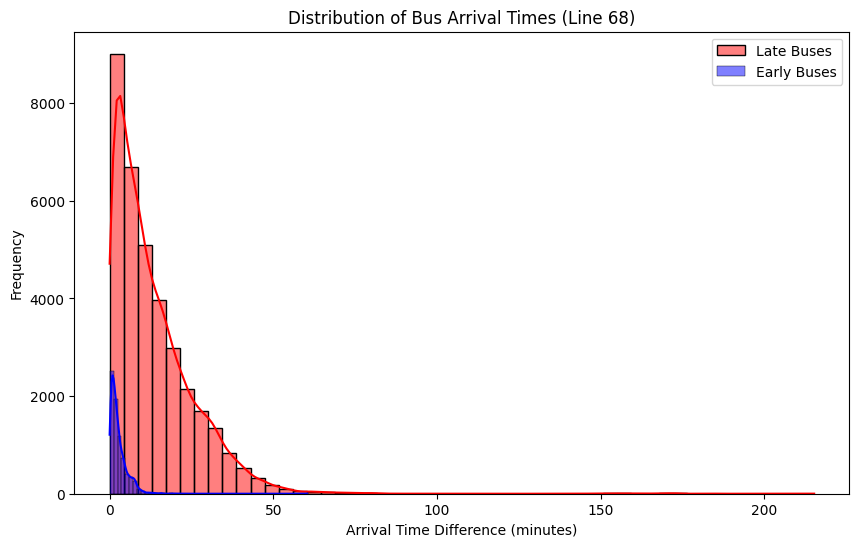

In [16]:
# Plot the distribution of late and early buses in minutes
plt.figure(figsize=(10,6))
sns.histplot(late_buses['arrival_time_diff_minutes'], color='red', bins=50, kde=True, label='Late Buses')
sns.histplot(early_buses['arrival_time_diff_minutes'], color='blue', bins=50, kde=True, label='Early Buses')
plt.title('Distribution of Bus Arrival Times (Line 68)')
plt.xlabel('Arrival Time Difference (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### **Analysis of Bus Arrival Time Differences**

The table summarizes the descriptive statistics for **late**, **early**, and **on-time buses** based on their arrival time differences. 

The histograms show the distribution of arrival time differences (in minutes) for both late buses (red) and early buses (blue).
The x-axis represents how early or late the buses arrived, while the y-axis shows the frequency of buses falling into each time category.

#### **What is Important to Notice?**

1. **Late Buses Dominate**:
   - There are significantly more **late buses (35,147)** than **early buses (7574)**, meaning delays are much more common than early arrivals.
   - The average delay for late buses is **13.48 minutes**, which is quite substantial and indicates delays are a frequent issue on this line.

2. **Variability in Delays**:
   - The **standard deviation** for late buses is **12.82 minutes**, showing a wide range in delay times. This means some buses are just slightly late, while others are much more delayed (up to **200 minutes** from schedule).
   - In contrast, early buses show a lower variability (**2.63 minutes standard deviation**), meaning early arrivals tend to be more consistent and typically within a small range (most early buses arrive only 2-3 minutes early).

3. **Extreme Cases**:
   - The **maximum delay** for late buses is **215.17 minutes**, (over 3.5 hours), which suggests that while most delays are moderate, there are rare but extreme cases that could indicate operational issues.
   - The **maximum early arrival** is **60.36 minutes**, which could be an outlier or due to scheduling inefficiencies.


#### **Conclusions**:
- **Delays are the norm**: Most buses on line 68 arrive later than scheduled, with an average delay of **13.48 minutes**. This consistent lateness suggests potential issues in the scheduling or traffic conditions that impact punctuality.
- **Early arrivals are less frequent and less severe**: When buses arrive early, they typically arrive only a few minutes ahead of schedule, with fewer extreme cases.


## Analyze Delays by **Time of Day**
Let’s start by breaking down the delays based on the hour of the day. This will help us understand how bus performance changes over the course of the day.

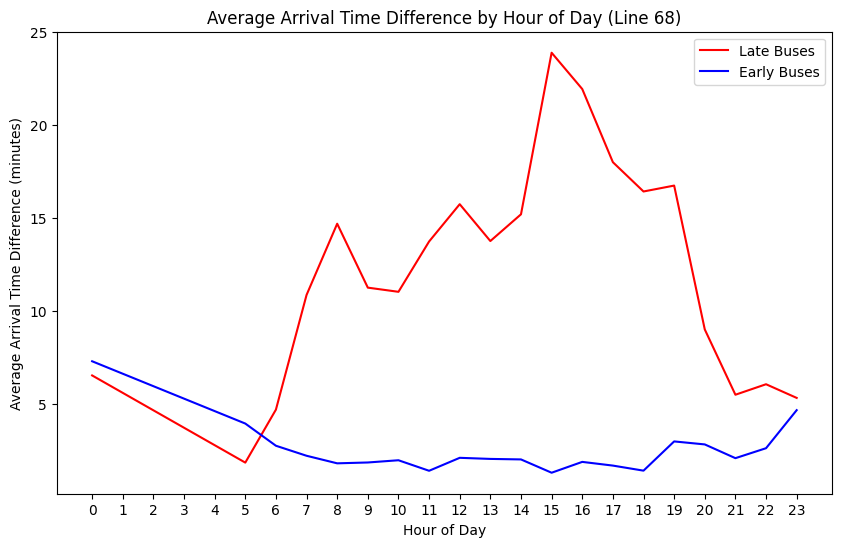

In [17]:
# Group by hour of day and calculate the mean delay for late, early, and on-time buses
late_delay_by_hour = late_buses.groupby('scheduled_arrival_time__hour')['arrival_time_diff_minutes'].mean()
early_delay_by_hour = early_buses.groupby('scheduled_arrival_time__hour')['arrival_time_diff_minutes'].mean()
on_time_by_hour = on_time_buses.groupby('scheduled_arrival_time__hour')['arrival_time_diff_minutes'].mean()

# Plot the mean delay by hour of day for late, early, and on-time buses
plt.figure(figsize=(10,6))
sns.lineplot(x=late_delay_by_hour.index, y=late_delay_by_hour.values, label='Late Buses', color='red')
sns.lineplot(x=early_delay_by_hour.index, y=early_delay_by_hour.values, label='Early Buses', color='blue')
sns.lineplot(x=on_time_by_hour.index, y=on_time_by_hour.values, label='On-Time Buses', color='green')
plt.title('Average Arrival Time Difference by Hour of Day (Line 68)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Arrival Time Difference (minutes)')
plt.xticks(ticks=range(0, 24, 1)) 
plt.legend()
plt.show()

### **Average Arrival Time Difference by Hour of Day**

This plot shows the **average arrival time difference** (in minutes) for **late** and **early buses** on **line 68** throughout the day. The **x-axis** represents the **hour of the day** (0-23), and the **y-axis** shows the average arrival time difference in minutes. The lines represent:
- **Red line**: Late buses.
- **Blue line**: Early buses.

#### **What is Important to Notice?**

1. **Morning Rush Hour Peak**:
   - Delays peak sharply during the **morning rush hour** (7 AM - 9 AM), with buses being delayed by an average of **over 20 minutes** at 8 AM.
   - This reflects the heavy traffic and congestion typical of the morning commute in Israel.

2. **Midday Stability**:
   - Between **10 AM and 4 PM**, delays stabilize, with average delays ranging between **10-15 minutes**.
   - This suggests that the buses perform more consistently during **non-peak hours** in the middle of the day.

3. **Evening Rush Hour Delays**:
   - Delays increase again during the **evening rush hour** (5 PM - 6 PM), though not as severely as in the morning. By 5 PM, buses are delayed by about **15 minutes**.

4. **Late Night Performance**:
   - Delays drop off significantly after **8 PM**, with minimal delays late at night (less than **5 minutes** after 9 PM).
   - Early buses are also more common in the early morning (before 6 AM) and late at night (after 9 PM), where buses arrive **4-6 minutes early** due to lighter traffic.

#### **Conclusions**:

- **Rush Hour Delays**: The most severe delays occur during the **morning rush hour** (7 AM - 9 AM), with delays also increasing during the **evening rush hour** (5 PM - 6 PM).
- **Midday Stability**: Buses perform more consistently during the **midday** hours, where traffic is lighter.
- **Off-Peak Hours**: Early buses tend to arrive during **off-peak** hours (early morning and late night), reflecting better performance when traffic is less congested.

## Analyze Delays by **Day of the Week**

Now we will break down the delays based on the day of the week


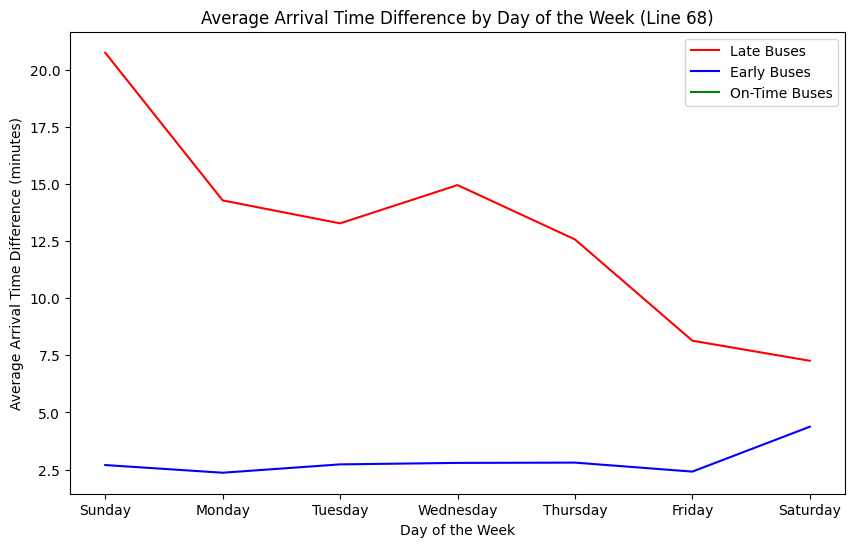

In [22]:
# Create a mapping to start the week on Sunday (6) and end on Saturday (5)
day_order = [6, 0, 1, 2, 3, 4, 5]  # Sunday to Saturday

# Group by day of the week and calculate the mean delay for late, early, and on-time buses
late_delay_by_day = late_buses.groupby('scheduled_arrival_time__day_of_week')['arrival_time_diff_minutes'].mean().reindex(day_order)
early_delay_by_day = early_buses.groupby('scheduled_arrival_time__day_of_week')['arrival_time_diff_minutes'].mean().reindex(day_order)
on_time_by_day = on_time_buses.groupby('scheduled_arrival_time__day_of_week')['arrival_time_diff_minutes'].mean().reindex(day_order)

# Create labels for the days of the week starting with Sunday
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plot the mean delay by day of the week for late, early, and on-time buses
plt.figure(figsize=(10,6))
sns.lineplot(x=day_labels, y=late_delay_by_day.values, label='Late Buses', color='red')
sns.lineplot(x=day_labels, y=early_delay_by_day.values, label='Early Buses', color='blue')
sns.lineplot(x=day_labels, y=on_time_by_day.values, label='On-Time Buses', color='green')
plt.title('Average Arrival Time Difference by Day of the Week (Line 68)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Time Difference (minutes)')
plt.legend()
plt.show()


### **Average Arrival Time Difference by Day of the Week**

This plot shows the **average arrival time difference** (in minutes) for **late** and **early buses** on **line 68** across the days of the week. The **x-axis** represents the **days of the week** (starting from **Sunday** and ending on **Saturday**), while the **y-axis** represents the average arrival time difference in minutes.

#### **What is Important to Notice?**

1. **Late Buses Peak on Sunday**:
   - The highest delays are on **Sunday**, with buses being delayed by an average of **over 20 minutes**.
   - Delays decrease on **Monday** and remain stable from **Tuesday to Thursday** at around **12-14 minutes**.
   - The delays drop significantly on **Friday** and even more on **Saturday**, where the average delay is just over **8 minutes**.

2. **Early Buses Remain Consistent**:
   - Early buses consistently arrive around **2.5 to 3 minutes early** across all days of the week.
   - There’s a slight increase in early arrivals on **Saturday**, where buses arrive **closer to 3.5 minutes early**, likely due to lighter weekend traffic.

3. **Weekend vs. Weekday Delays**:
   - **Friday** and **Saturday** show significantly lower delays compared to the **Israeli workweek** (Sunday to Thursday). This reflects the lighter traffic conditions during the weekend, particularly on **Shabbat** (Saturday).

#### **Conclusions**:

- **Weekday Delays**: Delays are most severe during the **Israeli workweek**, with **Sunday** being particularly problematic.
- **Weekend Improvement**: The decrease in delays on **Friday** and **Saturday** suggests that lighter traffic over the weekend leads to better bus performance.
- **Consistent Early Arrivals**: Early buses remain consistent across all days, but perform best on **Saturday**, with a slight improvement due to reduced weekend traffic.



## Analyze delays by Day of the Week and Hour of the Day


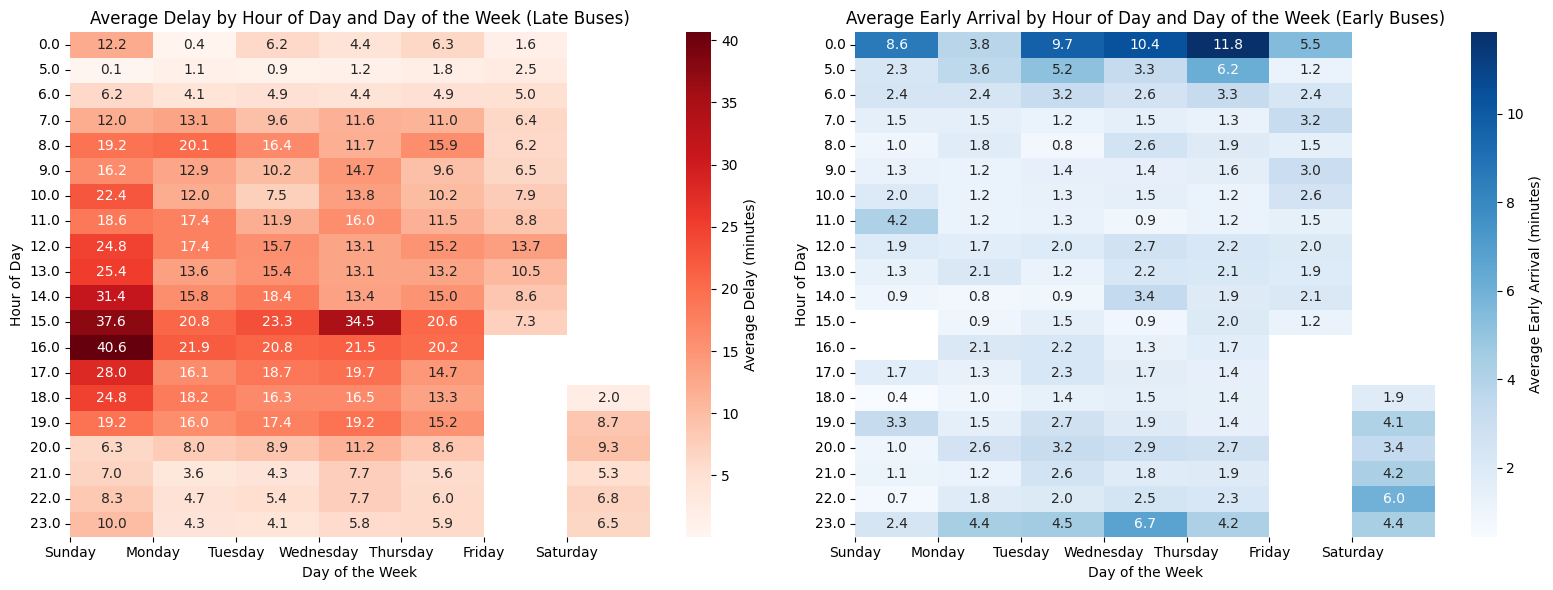

In [35]:
late_heatmap_data = late_buses.pivot_table(index='scheduled_arrival_time__hour', columns='scheduled_arrival_time__day_of_week', 
                                           values='arrival_time_diff_minutes', aggfunc='mean').reindex(columns=day_order)

early_heatmap_data = early_buses.pivot_table(index='scheduled_arrival_time__hour', columns='scheduled_arrival_time__day_of_week', 
                                             values='arrival_time_diff_minutes', aggfunc='mean').reindex(columns=day_order)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Late Buses Heatmap
sns.heatmap(late_heatmap_data, cmap='Reds', annot=True, fmt=".1f", cbar_kws={'label': 'Average Delay (minutes)'}, ax=axes[0])
axes[0].set_title('Average Delay by Hour of Day and Day of the Week (Late Buses)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_labels)
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Hour of Day')

# Plot Early Buses Heatmap
sns.heatmap(early_heatmap_data, cmap='Blues', annot=True, fmt=".1f", cbar_kws={'label': 'Average Early Arrival (minutes)'}, ax=axes[1])
axes[1].set_title('Average Early Arrival by Hour of Day and Day of the Week (Early Buses)')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_labels)
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

### **Average Delay by Hour of Day and Day of the Week (Late Buses)**

#### **What is Important to Notice?**

1. **Morning Rush Hour Peak**:
   - **Sunday and Monday mornings** show the highest delays, with buses delayed by over **20 minutes**. 
   - **Wednesday** afternoon has a peak delay of **34.5 minutes** around **4 PM**.

2. **Evening Rush Hour**:
   - Delays remain high during the **evening rush hour** (3 PM - 7 PM), especially on **Wednesday**, with delays over **23 minutes**.

3. **Weekend Improvement**:
   - **Saturday** shows minimal delays, with most delays under **6 minutes**.

#### **Conclusions**:
- **Sunday and Wednesday** see the worst delays, especially during rush hours.
- **Saturday** consistently shows the lowest delays, reflecting lighter weekend traffic.


### **Average Early Arrival by Hour of Day and Day of the Week (Early Buses)**

#### **What is Important to Notice?**

1. **Early Morning**:
   - Buses arrive the earliest before **6 AM**, particularly on **Monday** and **Friday**, with arrivals up to **11.8 minutes early**.

2. **Midday Consistency**:
   - Between **12 PM and 6 PM**, buses typically arrive **1-3 minutes early**.

3. **Late Night Hours**:
   - **Saturday** night shows the most early arrivals, with buses arriving **6 minutes early** around **11 PM**.

#### **Conclusions**:
- Buses are more likely to arrive early in the **early morning** and **late night**, especially on **Saturday**.
- **Midday buses** show consistent early arrivals, typically arriving a few minutes ahead of schedule.


## **Time Features in Bus Arrival Analysis Conclusion**
Our analysis of bus arrival times for line 68 has revealed significant insights about how time impacts bus delays and early arrivals. We’ve observed clear patterns across both days of the week and hours of the day, which provide valuable context for understanding bus performance and scheduling efficiency.

#### **Impact on the Project**
**Time-of-Day and Day-of-Week Effects**: The strong correlation between time features (hour and day) and bus performance underlines the importance of accounting for these variables in any predictive model for bus arrival times. By incorporating time-of-day and day-of-week features, we can improve the accuracy of predictions, as rush hours and weekends heavily influence bus punctuality.


## **Outliers Analysis**

In this part we will try to understand the **outliers**—the extreme cases where the system experiences significant deviations from its usual performance. In this case, for **line 68**, we are investigating **extreme delays** (over 60 minutes) and **extreme early arrivals** (more than 30 minutes early).


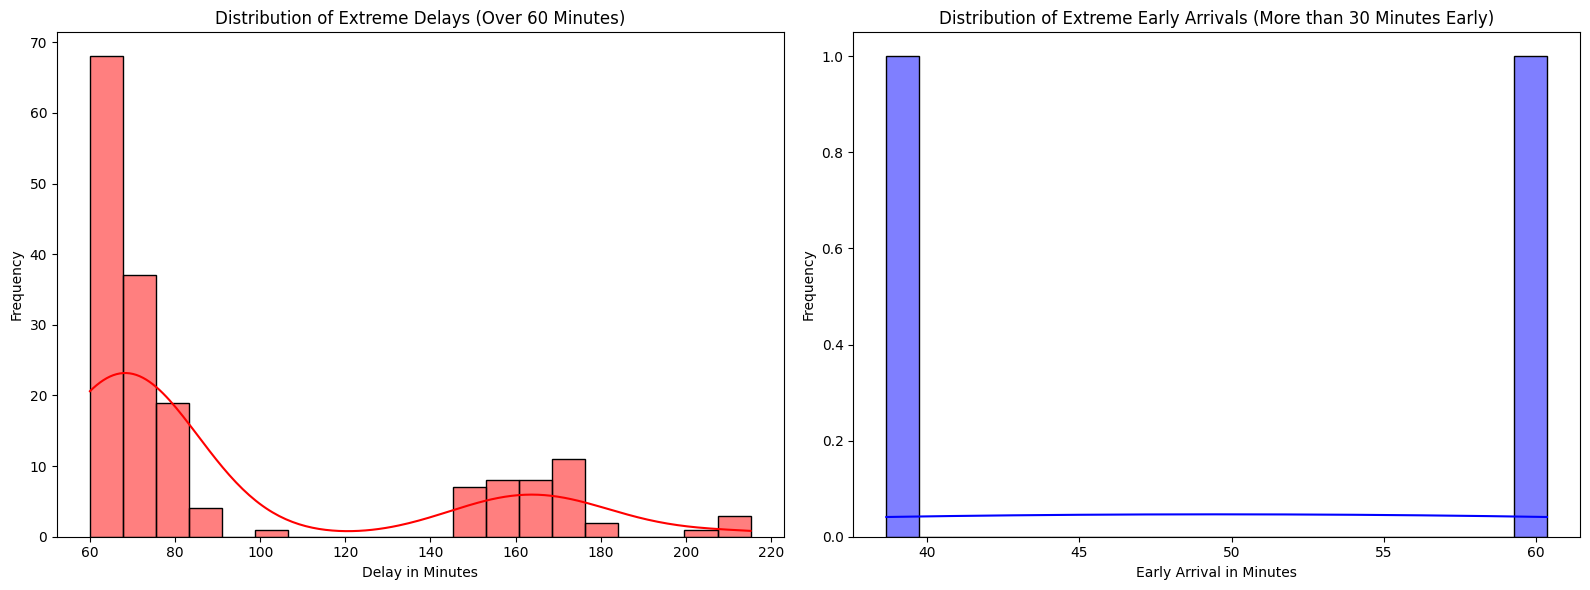

In [36]:
# Filter extreme delays (e.g., delays > 60 minutes) and early arrivals (e.g., more than 30 minutes early)
extreme_delays = late_buses[late_buses['arrival_time_diff_minutes'] > 60]
extreme_early_arrivals = early_buses[early_buses['arrival_time_diff_minutes'] > 30]

# Display the top extreme delays and early arrivals
extreme_delays.head()
extreme_early_arrivals.head()

# Plot histograms of extreme delays and early arrivals side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(extreme_delays['arrival_time_diff_minutes'], bins=20, color='red', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Extreme Delays (Over 60 Minutes)')
axes[0].set_xlabel('Delay in Minutes')
axes[0].set_ylabel('Frequency')

sns.histplot(extreme_early_arrivals['arrival_time_diff_minutes'], bins=20, color='blue', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Extreme Early Arrivals (More than 30 Minutes Early)')
axes[1].set_xlabel('Early Arrival in Minutes')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **Distribution of Extreme Delays and Early Arrivals**

#### **What is Important to Notice?**

1. **Extreme Delays (Over 60 Minutes)**:
   - The majority of extreme delays are clustered between **60 and 70 minutes**. This suggests that once buses are delayed beyond an hour, they tend to stay within this range.
   - There is a smaller but notable cluster of delays around **160 to 180 minutes**, indicating rare but significant disruptions. These could be due to unusual circumstances such as accidents or major traffic events.
   - A few extreme cases show delays beyond **200 minutes**, which are likely isolated incidents and deserve further investigation to understand the causes.

2. **Extreme Early Arrivals (More than 30 Minutes Early)**:
   - Unlike delays, extreme early arrivals are rare. There is only one notable early arrival around **40 minutes early**, which indicates that extreme early arrivals are highly uncommon compared to delays.
   - This suggests that buses are far more likely to be delayed than to arrive significantly early, likely due to traffic congestion and operational constraints.

#### **Conclusions**:

- **Delays are More Common**: Extreme delays occur much more frequently than extreme early arrivals, which are rare. This aligns with the overall trend that buses tend to face more delays than arriving early.
- **Operational Disruptions**: The presence of a small cluster of delays beyond **160 minutes** points to occasional severe disruptions in bus schedules, possibly due to major incidents. These cases may require further investigation and operational improvements.
- **Rare Early Arrivals**: The near-absence of extreme early arrivals indicates that the bus service is generally aligned with the schedule, and when early, it’s usually within a predictable range (i.e., not excessively early).



### Outliers impact
We saw the distribution of outliers in the previous section, Now we would like to determine weather they should be taken into account or should be ignored 

In [42]:
# Total number of data points
total_data_points = len(line_68_results)

# Number of extreme delays (over 60 minutes)
extreme_delay_count = len(extreme_delays)

# Number of extreme early arrivals (more than 30 minutes early)
extreme_early_count = len(extreme_early_arrivals)

# Calculate the proportion of extreme delays and early arrivals
extreme_delay_percentage = (extreme_delay_count / total_data_points) * 100
extreme_early_percentage = (extreme_early_count / total_data_points) * 100

print(f"Percentage of Extreme Delays (Over 60 Minutes): {extreme_delay_percentage:.2f}%")
print(f"Percentage of Extreme Early Arrivals (More than 30 Minutes Early): {extreme_early_percentage:.2f}%")


Percentage of Extreme Delays (Over 60 Minutes): 0.34%
Percentage of Extreme Early Arrivals (More than 30 Minutes Early): 0.00%


### **Outliers Impact: Key Insights**

1. **Extreme Delays (Over 60 Minutes)**:
   - Extreme delays account for **only 0.34%** of the total data points, indicating that they are **rare occurrences** in the dataset. This small percentage suggests that these extreme cases are not a significant part of the overall dataset and can likely be **ignored** in the predictive model or treated separately as special cases.

2. **Extreme Early Arrivals (More than 30 Minutes Early)**:
   - Extreme early arrivals are even rarer, making up **0.00%** of the data. This shows that **extreme early arrivals are virtually non-existent** in this dataset, making it reasonable to ignore them without worrying about the model’s accuracy.

### **Conclusion**:

Given the low frequency of extreme outliers (both in terms of delays and early arrivals), these rare events can be **ignored** in the main predictive model without a significant impact on overall accuracy. This will help simplify the model while ensuring it focuses on the more common patterns of bus performance.

However, if these outliers are of particular operational interest (e.g., understanding why certain buses get delayed over an hour), they can still be analyzed separately for insights or handled in a more specific model targeting extreme events.


## Bus Arrival Time Analysis

In this cell, we're performing several key steps to analyze bus arrival times:

1. **Calculate Arrival Time Difference**: We first calculate the difference between the estimated arrival time and the scheduled arrival time for each bus. This is done by subtracting the `scheduled_arrival_time` from the `estimated_arrival_time`. The result is stored in a new column in our DataFrame, `results`, named `arrival_time_diff`.

2. **Define Bus Classification Function**: We then define a function, `classify_bus`, that takes in the arrival time difference and a threshold (in minutes) as parameters. This function classifies the bus status into one of four categories:

   - 'Missing': If the arrival time difference is null.
   - 'Late': If the bus arrived later than the scheduled time by more than the threshold.
   - 'Early': If the bus arrived earlier than the scheduled time by more than the threshold.
   - 'On Time': If the bus arrived within the threshold window.

3. **Apply Classification Function**: We set the threshold to 3 minutes and apply the `classify_bus` function to the `arrival_time_diff` column of our DataFrame. The resulting bus status for each row is stored in a new column, `bus_status`.

This preprocessing is key step as it allows us to categorize bus arrival times and understand the distribution of 'Late', 'Early', 'On Time', and 'Missing' statuses across different bus journeys. This categorized data can then be used for further analysis, such as identifying patterns or trends in bus arrival times, or investigating the factors that might influence a bus's punctuality.


In [28]:
def classify_buses(results):
    conditions = [
        results['arrival_time_diff'].isna(),
        results['arrival_time_diff'] > pd.Timedelta(0),
        results['arrival_time_diff'] < pd.Timedelta(0),
        results['arrival_time_diff'] == pd.Timedelta(0),
    ]
    choices = ['missing', 'late', 'early', 'on_time']
    results['bus_status'] = np.select(conditions, choices, default='unknown')

    # One-hot encoding using pandas.get_dummies
    one_hot_encoded = pd.get_dummies(results['bus_status'], prefix='is', dtype=int)
    results = pd.concat([results, one_hot_encoded], axis=1)

    return results

### Analyzing Bus Delays by City

In this analysis, we are investigating the delay of buses across different cities.

The Python code provided creates a pivot table from the `results` DataFrame, using the 'gtfs_stop_city' column as the index and the 'bus_status_num' column as the values. The aggregation function used is 'mean', which gives us the average delay for each city.

A function `reverse_string(s)` is defined and applied to the index of the pivot table to reverse the order of the text.

A heatmap is then created using seaborn's `sns.heatmap()` function, visualizing the average delay of buses in different cities. The color intensity in the heatmap represents the magnitude of the delay.

By examining this heatmap, we can identify which cities experience the most significant bus delays.


In [51]:
def plot_city_heatmap(results):
    pivot_table_city = results.pivot_table(index='gtfs_stop_city', values='bus_status_num', aggfunc='mean')

    def reverse_string(s):
        return s[::-1]

    pivot_table_city.index = pivot_table_city.index.map(reverse_string)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_city, annot=True, cmap='coolwarm')
    plt.show()

# Applying Analysis to the Entire Dataset

In this section, we will apply the analysis we have developed to the entire dataset. Given the large size of the data (approximately 800GB), we will process the data in batches. This approach allows us to efficiently handle the data without overloading the memory.

When splitting into batches we can go in few different approaches:
1. Based on batch size limit - in this approach we only care about the size of the batch without any regard to its content.
2. Based on journey_ref - in this approach we will process each journey on its own. The main downside is the amount of batches - millions. which might lead to excessive overhead.
3. based on line_ref - in this approach we will process all journeys of a certain line in each batch. This could be helpful for training a model later in the notebook.
4. based on route_id - similar to the previous approach. could be better for a model training because its more unique.

## Splitting based on batch size

When first starting this part, the approach taken for splitting into batches was the first - based on batch size. 
After many hours of trial and error, many hours of data processing and many many hours of debugging - A conclusion was reached that a different approach was needed and this part must be ditched.
This code is still crucial for the project, so although it won't be used, it will not be deleted.
It should be noted that the code itself works, but every refinement needed in the created batches resulted in a very long wait time for the processing.

The steps we will follow are:

1. **Batch Creation**: We will create data batches, ensuring that each batch does not exceed a specified size limit. To maintain data integrity, we will ensure that all related lines (i.e., lines with the same 'siri_journey_ref') are included in the same batch.

2. **Batch Analysis**: We will apply our analysis to each batch individually. This includes any data cleaning, transformation, and statistical analysis we have previously defined.

3. **Results Aggregation**: After analyzing each batch, we will aggregate the results. This could involve combining the results into a single data structure, or it could involve saving the results of each batch's analysis to disk.

By processing the data in batches, we can scale our analysis to handle large datasets that would not otherwise fit into memory. Let's get started!


In [29]:
def process_batch_df(batch_df):
    # Process the DataFrame
    df_bus_journey_stops, df_locations = process_dataframe(batch_df)

    print(f'Processed {len(df_bus_journey_stops)} bus journey stops and {len(df_locations)} locations.')
    # Process the locations
    df_locations = process_locations(df_locations)

    # Calculate the arrival times
    results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=110)

    print(f'Calculated arrival times for {len(results)} stops.')
    # Calculate the bus stats and update the DataFrame
    results = classify_buses(results)

    # Process the results
    results = data_processing.time_features_extraction(results)

    return results

def save_processed_batch(batch_df):
    batch_num = uuid.uuid4()
    output_file = f'{DATA_FOLDER}/processed_batches/processed_batch_{batch_num}.parquet'
    print(f'Saving processed batch to {output_file}')
    batch_df.to_parquet(output_file, index=False, engine='fastparquet')    

def process_batches_parallel(batch_dfs):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch_df, batch_dfs))
    return results

In [20]:
def process_parquet_files(parquet_dir, batch_size_gb, num_batches):
    last_batch_journey_refs = None
    start_file = None
    start_pos = 0

    while True:
        batches = []
        for _ in range(num_batches):
            batch_df, last_batch_journey_refs, remaining_chunk, chunk_iter, start_file, start_pos = data_processing.create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs, start_file, start_pos)
            batches.append(batch_df)

            # If there are no more files to process, break the loop
            if start_file is None:
                break

        if not batches:
            break

        processes_batches =  process_batches_parallel(batches)

        for batch in processes_batches:
            save_processed_batch(batch)

        batches.clear()

    return results

In [18]:
batch_df, _, _, _, _, _ = data_processing.create_batch_df(f'{DATA_FOLDER}/concatenated_data_parquet', 0.2)

In [24]:
process_parquet_files(f'{DATA_FOLDER}/concatenated_data_parquet', 0.4, 3)

## Splitting based on route_id


In [30]:
# Function to establish a connection to the PostgreSQL database
def connect_to_db():
    # Replace the following with your database connection details
    user = 'postgres'
    password = 'postgres'
    host = 'localhost'
    port = '5433'
    db = 'siri_2023'
    return create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}')

def process_chunk(chunk, engine, file_name):
    chunk.to_sql('raw_data', engine, if_exists='append', index=False)
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Saved a chunk of {file_name} to the database.')

def process_file(file, engine):
    parquet_file = pq.ParquetFile(file)
    chunk_iter = parquet_file.iter_batches(batch_size=1000000)  # Adjust batch size as needed
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        futures = []
        for batch in chunk_iter:
            chunk = pd.DataFrame(batch.to_pandas())
            # Submit each chunk to be processed by one of the workers
            futures.append(executor.submit(process_chunk, chunk, engine, os.path.basename(file)))
        concurrent.futures.wait(futures)

def save_to_db(parquet_dir, engine):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit each file to be processed in parallel
        futures = [executor.submit(process_file, file, engine) for file in parquet_files]
        concurrent.futures.wait(futures)



# Connect to the database
engine = connect_to_db()


### Processing Strategy

After deciding to load all data into PostgreSQL, the next step is processing it.

Processing the data still needs to be done in batches. We aim to choose a batching strategy that minimizes processing time. Because using PostgreSQL eliminates many of the complications we encountered earlier with file-based methods, we now have more flexibility in choosing processing strategies. This increased flexibility will not affect the later stages of model training.

When choosing the group, we must choose a group that include an entire journey from start to end.
For example - A group made from the `gtfs_route_mkt` is a good group because each journey has exactly one `gtfs_route_mkt`, On the other end, a group made from `siri_stop_code` is not a good group because each journey has many bus stops.

In [ ]:

def create_sql_query(table_name, group_column, value, start_date=None, end_date=None):
    sql_query = f"SELECT * FROM {table_name} WHERE {group_column} = '{value}' AND gtfs_arrival_time IS NOT NULL"
    if start_date is not None and end_date is not None:
        sql_query += f" AND recorded_at_time BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date is not None:
        sql_query += f" AND recorded_at_time >= '{start_date}'"
    elif end_date is not None:
        sql_query += f" AND recorded_at_time <= '{end_date}'"

    return sql_query

def process_single_value(args):
    engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index = args
    def log(message):
        if enable_logging:
            print(message)
    
    fetch_start_time = time.time()
    sql_query = create_sql_query(table_name, group_column, value, start_date, end_date)
    df = pd.read_sql(sql_query, engine, parse_dates=['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time'])
    df.drop(columns=['original_file'], inplace=True)
        
    fetch_end_time = time.time()
    log(f"Data for '{value}' in '{group_column}' fetched in {fetch_end_time - fetch_start_time:.2f} seconds.")
    
    group_start_time = time.time()
    
    # Process the data (assuming process_batch_df is a function you've defined to process your data)
    results = process_batch_df(df)
    
    # Save results in db
    results.to_sql('processed_data', engine, if_exists='append', index=False)
    
    group_end_time = time.time()
    log(f" [{index+1}/{total_values}] Processed group '{value}' in '{group_column}' in {group_end_time - group_start_time:.2f} seconds.")

def create_distinct_query(table_name, group_column, limit=None, offset=None):
        distinct_query = f"""
                            SELECT DISTINCT {group_column} 
                            FROM {table_name} 
                            WHERE {group_column} IS NOT NULL 
                            AND gtfs_arrival_time IS NOT NULL 
                            AND {group_column} NOT IN (SELECT DISTINCT {group_column} FROM processed_data)
                            """
        if limit is not None:
            distinct_query += f" LIMIT {limit}"
        if offset is not None:
            distinct_query += f" OFFSET {offset}"
        return distinct_query

def process_data_grouped_by_column(engine, table_name, group_column, start_date=None, end_date=None, limit=None, offset=None, enable_logging=False):
    start_time = time.time()
    if enable_logging:
        print(f"Starting processing for table '{table_name}' grouped by '{group_column}'")
    
    distinct_query = create_distinct_query(table_name, group_column, limit, offset)
    distinct_values_df = pd.read_sql(distinct_query, engine)
    total_values = len(distinct_values_df)
    if enable_logging:
        print(f"Distinct query executed and fetched {total_values} distinct values.")
    
    if limit is not None:
        distinct_values_df = distinct_values_df.head(limit)     
    
    args = [(engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index) for index, value in enumerate(distinct_values_df[group_column])]
    
    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        futures = [executor.submit(process_single_value, arg) for arg in args]
        for future in concurrent.futures.as_completed(futures):
            future.result()  # You can handle exceptions here if needed
    
    end_time = time.time()
    if enable_logging:
        print(f"Total processing time for table '{table_name}' grouped by '{group_column}': {end_time - start_time:.2f} seconds.")

In [12]:
def create_sql_query(table_name, group_column, value, start_date=None, end_date=None):
    sql_query = f"SELECT * FROM {table_name} WHERE {group_column} = '{value}' AND gtfs_arrival_time IS NOT NULL"
    if start_date is not None and end_date is not None:
        sql_query += f" AND recorded_at_time BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date is not None:
        sql_query += f" AND recorded_at_time >= '{start_date}'"
    elif end_date is not None:
        sql_query += f" AND recorded_at_time <= '{end_date}'"

    return sql_query

def process_single_value(args):
    engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index = args
    def log(message):
        if enable_logging:
            print(message)
    
    fetch_start_time = time.time()
    sql_query = create_sql_query(table_name, group_column, value, start_date, end_date)
    df = pd.read_sql(sql_query, engine, parse_dates=['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time'])
    df.drop(columns=['original_file'], inplace=True)
        
    fetch_end_time = time.time()
    log(f"Data for '{value}' in '{group_column}' fetched in {fetch_end_time - fetch_start_time:.2f} seconds.")
    
    group_start_time = time.time()
    
    # Process the data (assuming process_batch_df is a function you've defined to process your data)
    results = process_batch_df(df)
    
    # Save results in db
    results.to_sql('processed_data_partitioned', engine, if_exists='append', index=False)
    
    group_end_time = time.time()
    log(f" [{index+1}/{total_values}] Processed group '{value}' in '{group_column}' in {group_end_time - group_start_time:.2f} seconds.")

def create_distinct_query(table_name, group_column, limit=None, offset=None):
        distinct_query = f"""
                            SELECT DISTINCT {group_column} 
                            FROM {table_name} 
                            WHERE {group_column} IS NOT NULL 
                            """
        if limit is not None:
            distinct_query += f" LIMIT {limit}"
        if offset is not None:
            distinct_query += f" OFFSET {offset}"
        return distinct_query
    


In [31]:
def process_data_partitioned(raw_table_name, processed_table_name, start_date, end_date, worker_batch_size=150):
    start_time = time.time()
    print(f"Starting processing for table '{raw_table_name}' partitioned by date")
    # Create a list of date ranges
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_ranges = []
    current_date = start_date
    while current_date < end_date:
        first_day_of_next_month = current_date.replace(month=current_date.month + 1, day=1)
        next_date = min(first_day_of_next_month, end_date)
        date_ranges.append((current_date, next_date))
        current_date = next_date
    print(f"{date_ranges}")
    
    # Process each date range in parallel
    args = [(raw_table_name, processed_table_name, start, end, worker_batch_size) for start, end in date_ranges]
    for arg in args:
        process_single_date_range(arg)
    end_time = time.time()
    print(f"Total processing time for table '{raw_table_name}' partitioned by date: {end_time - start_time:.2f} seconds.")


def process_batch(args):
    """Process a batch and save directly to temp table"""
    batch_refs, raw_table_name, temp_table_name, processed_table_name, worker_id = args
    
    try:
        start_time = time.time()
        engine = connect_to_db()
        
        query = f"""
            SELECT *
            FROM {raw_table_name}
            WHERE siri_journey_ref IN ({','.join(map(repr, batch_refs))})
        """
        df = pd.read_sql(query, engine)
        
        if df.empty:
            engine.dispose()
            return
            
        end_time = time.time()
        print(f"Thread {worker_id}: Fetched batch of {len(batch_refs)} references in {end_time - start_time:.2f} seconds")
        
        start_time = time.time()
        results = process_batch_df(df)
        end_time = time.time()
        print(f"Thread {worker_id}: Processed batch of {len(batch_refs)} references in {end_time - start_time:.2f} seconds")
        
        # Save to temp table
        start_time = time.time()
        connection = engine.raw_connection()
        cursor = connection.cursor()
        
        if 'serial_id' in results.columns:
            results = results.drop('serial_id', axis=1)
            
        output = StringIO()
        results.to_csv(output, sep='\t', header=False, index=False, na_rep='\\N')
        output.seek(0)
        
        cursor.copy_from(
            output,
            temp_table_name,
            null='\\N',
            columns=results.columns.tolist()
        )
        connection.commit()
        
        end_time = time.time()
        print(f"Thread {worker_id}: Saved {len(results)} rows in {end_time - start_time:.2f} seconds")
        
        cursor.close()
        connection.close()
        engine.dispose()

    except Exception as e:
        print(f"Thread {worker_id} encountered error: {str(e)}")
        if 'engine' in locals():
            engine.dispose()

def check_and_move_data(temp_table_name, processed_table_name, threshold=500000):
    """Check temp table size and move data if threshold reached"""
    try:
        engine = connect_to_db()
        connection = engine.raw_connection()
        cursor = connection.cursor()
        
        cursor.execute(f"SELECT COUNT(*) FROM {temp_table_name}")
        count = cursor.fetchone()[0]
        
        if count >= threshold:
            start_time = time.time()
            
            cursor.execute(f"""
                BEGIN;
                INSERT INTO {processed_table_name}
                SELECT * FROM {temp_table_name};
                
                TRUNCATE TABLE {temp_table_name};
                COMMIT;
            """)
            connection.commit()
            
            end_time = time.time()
            print(f"Moved {count} rows to main table in {end_time - start_time:.2f} seconds")
            
        cursor.close()
        connection.close()
        engine.dispose()
        
        return count
        
    except Exception as e:
        print(f"Error checking/moving data: {str(e)}")
        if 'engine' in locals():
            engine.dispose()
        return 0

def process_single_date_range(args):
    raw_table_name, processed_table_name, start_date, end_date, worker_batch_size = args
    print(f"Processing date range {start_date} to {end_date}")
    
    engine = connect_to_db()
    connection = engine.raw_connection()
    cursor = connection.cursor()
    
    # Create temporary table
    temp_table_name = f"temp_{processed_table_name}_{int(time.time())}"
    print(f"Creating temporary table {temp_table_name}")
    
    try:
        # Create temp table with same structure
        cursor.execute(f"""
            CREATE UNLOGGED TABLE {temp_table_name} 
            (LIKE {processed_table_name} INCLUDING ALL)
        """)
        connection.commit()
        
        start_time = time.time()
        print(f"Fetching exclusive journey references for date range {start_date} to {end_date}")
        
        # Calculate the start of the previous month
        previous_month_start = (start_date.replace(day=1) - timedelta(days=1)).replace(day=1)
        previous_month_end = start_date - timedelta(days=1)
        
        # Modified query to exclude refs from previous month
        journey_refs = pd.read_sql(
            f"""
            WITH current_month_refs AS (
                SELECT DISTINCT siri_journey_ref
                FROM {raw_table_name}
                WHERE recorded_at_time BETWEEN '{start_date}' AND '{end_date}'
            ),
            previous_month_refs AS (
                SELECT DISTINCT siri_journey_ref
                FROM {raw_table_name}
                WHERE recorded_at_time BETWEEN '{previous_month_start}' AND '{previous_month_end}'
            )
            SELECT siri_journey_ref
            FROM current_month_refs
            WHERE siri_journey_ref NOT IN (
                SELECT siri_journey_ref 
                FROM previous_month_refs
            )
            """,
            engine
        )
        
        end_time = time.time()
        print(f"Fetched {journey_refs.shape[0]} exclusive journey references in {end_time - start_time:.2f} seconds.")

        # Split journey references into batches
        journey_ref_batches = np.array_split(
            journey_refs['siri_journey_ref'].unique(), 
            max(len(journey_refs) // worker_batch_size, 1)
        )
        
        total_batches = len(journey_ref_batches)
        print(f"Total number of batches to process: {total_batches}")
        
        # Process batches using threads
        num_workers = min(12, len(journey_ref_batches))
        print(f"Processing with {num_workers} threads")
        
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = []
            completed_count = 0
            last_update_time = time.time()
            processing_start_time = time.time()
            
            for i, batch_refs in enumerate(journey_ref_batches):
                future = executor.submit(
                    process_batch, 
                    (batch_refs, raw_table_name, temp_table_name, processed_table_name, i)
                )
                futures.append(future)
                
            # Progress tracking variables
            update_interval = 5  # seconds between progress updates
            
            # Then monitor completion separately
            while futures:
                current_time = time.time()
                current_futures = futures.copy()
                completed = []
                
                for future in current_futures:
                    if future.done():
                        try:
                            future.result()  # Check for exceptions
                            completed.append(future)
                            completed_count += 1
                            
                            # Check if it's time to update progress
                            if current_time - last_update_time >= update_interval:
                                progress = (completed_count / total_batches) * 100
                                elapsed_time = current_time - processing_start_time
                                elapsed_delta = timedelta(seconds=int(elapsed_time))
                                
                                # Calculate estimated time remaining
                                if completed_count > 0:
                                    avg_time_per_batch = elapsed_time / completed_count
                                    remaining_batches = total_batches - completed_count
                                    estimated_time_remaining = avg_time_per_batch * remaining_batches
                                    remaining_delta = timedelta(seconds=int(estimated_time_remaining))
                                    
                                    print(f"\rProgress: {progress:.1f}% complete "
                                          f"({completed_count}/{total_batches} batches) | "
                                          f"Elapsed: {elapsed_delta} | "
                                          f"Remaining: {remaining_delta}\n",
                                          end="", flush=True)
                                
                                last_update_time = current_time
                            
                            if completed_count % 100 == 0:
                                print(f"\nChecking and moving data after {completed_count} batches")
                                check_and_move_data(temp_table_name, processed_table_name)
                                
                        except Exception as e:
                            print(f"\nBatch processing error: {str(e)}")
                            completed.append(future)
                
                # Remove completed futures from the main list
                futures = [f for f in futures if f not in completed]
                
                # Add a small sleep to prevent CPU spinning
                if futures:
                    time.sleep(0.1)
                    
        print("\nProcessing complete!")
        
        # Final move of any remaining data
        final_count = check_and_move_data(temp_table_name, processed_table_name, threshold=0)
        if final_count > 0:
            print(f"Moved final {final_count} rows to main table")
        
    finally:
        # Clean up
        cursor.execute(f"DROP TABLE IF EXISTS {temp_table_name}")
        connection.commit()
        cursor.close()
        connection.close()
        engine.dispose()
        
    total_time = time.time() - start_time
    total_delta = timedelta(seconds=int(total_time))
    print(f"Total processing time: {total_delta}")

In [ ]:
process_data_partitioned('raw_data_partitioned', 'processed_data_partitioned', START_DATE, END_DATE, 150)

### Processing the data
We will batch by `gtfs_route_mkt` and save back to the db after initial calculations

In [ ]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt',start_date=START_DATE, end_date=END_DATE, enable_logging=True)

Starting processing for table 'raw_data' grouped by 'gtfs_route_mkt'


## Analyze delays based on Day of the Week and Hour of the Day

In [4]:
query = """WITH classified_data AS (
    SELECT scheduled_arrival_time__hour, 
           scheduled_arrival_time__day_of_week,
           CASE 
               WHEN arrival_time_diff > 0 THEN 'Late'
               WHEN arrival_time_diff < 0 THEN 'Early'
               ELSE 'On-Time'
           END AS bus_status,
           CASE 
               WHEN arrival_time_diff < 0 THEN ROUND((arrival_time_diff / (60 * 1e9)), 2) * -1
               ELSE ROUND(arrival_time_diff / (60 * 1e9), 2)
           END AS adjusted_arrival_time_diff
    FROM processed_data
)
SELECT scheduled_arrival_time__hour, 
       scheduled_arrival_time__day_of_week,
       bus_status,
       AVG(adjusted_arrival_time_diff) AS mean,
       STDDEV(adjusted_arrival_time_diff) AS std,
       MIN(adjusted_arrival_time_diff) AS min,
       MAX(adjusted_arrival_time_diff) AS max,
       PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY adjusted_arrival_time_diff) AS "25%%",
       PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY adjusted_arrival_time_diff) AS "50%%",
       PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY adjusted_arrival_time_diff) AS "75%%",
       COUNT(*) AS total_trips
FROM classified_data
GROUP BY scheduled_arrival_time__hour, 
         scheduled_arrival_time__day_of_week, 
         bus_status
ORDER BY scheduled_arrival_time__day_of_week, 
         scheduled_arrival_time__hour, 
         bus_status;
"""

df = pd.read_sql(query, engine)

,scheduled_arrival_time__hour,scheduled_arrival_time__day_of_week,bus_status,mean,std,min,max,25%,50%,75%,total_trips
0,0.0,0.0,Early,9.645278,13.180268,0.00,145.61,2.3500,5.835,13.6775,1366
1,0.0,0.0,Late,6.247135,11.172971,0.01,178.07,0.7350,3.235,8.3600,384
2,1.0,0.0,Early,12.160085,10.456710,0.04,68.77,3.7700,9.080,18.1200,1293
3,1.0,0.0,Late,4.319634,5.663683,0.02,36.93,0.6675,2.245,7.5800,82
4,2.0,0.0,Early,5.940881,14.128654,0.00,868.31,1.1800,2.650,6.0100,5990


In [6]:
def plot_delays_heatmap(df):
    late_heatmap_data = df[df['bus_status'] == 'late'].pivot_table(index='scheduled_arrival_time__hour', columns='scheduled_arrival_time__day_of_week', values='mean').reindex(columns=day_order)
    early_heatmap_data = df[df['bus_status'] == 'early'].pivot_table(index='scheduled_arrival_time__hour', columns='scheduled_arrival_time__day_of_week', values='mean').reindex(columns=day_order)

    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Late Buses Heatmap
    sns.heatmap(late_heatmap_data, cmap='Reds', annot=True, fmt=".1f", cbar_kws={'label': 'Average Delay (minutes)'}, ax=axes[0])
    axes[0].set_title('Average Delay by Hour of Day and Day of the Week (Late Buses)')
    axes[0].set_xticks(range(7))
    axes[0].set_xticklabels(day_labels)
    axes[0].set_xlabel('Day of the Week')
    axes[0].set_ylabel('Hour of Day')

    # Plot Early Buses Heatmap
    sns.heatmap(early_heatmap_data, cmap='Blues', annot=True, fmt=".1f", cbar_kws={'label': 'Average Early Arrival (minutes)'}, ax=axes[1])
    axes[1].set_title('Average Early Arrival by Hour of Day and Day of the Week (Early Buses)')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(day_labels)
    axes[1].set_xlabel('Day of the Week')
    axes[1].set_ylabel('Hour of Day')

    plt.tight_layout()
    plt.show()

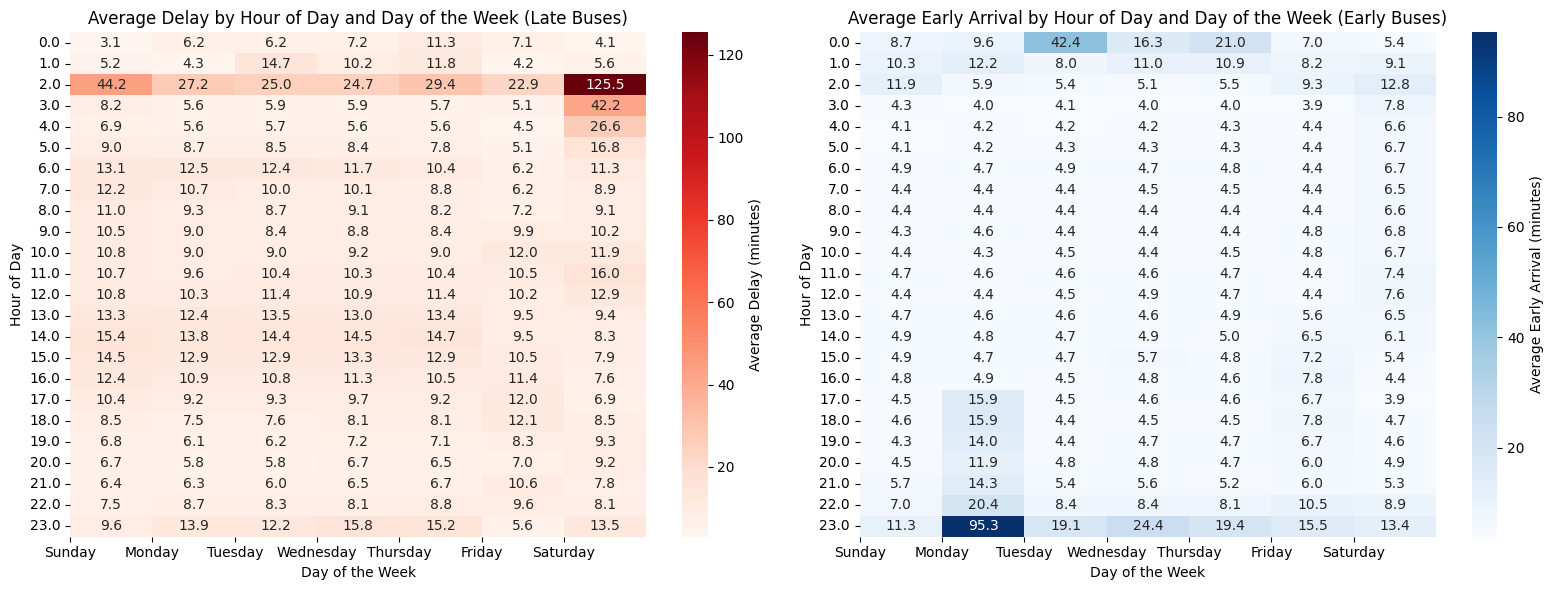

In [92]:
plot_delays_heatmap(df)

The heatmaps above visualize the distribution of bus delays across different hours of the day and days of the week for both late and early buses.

On the left, we see average delays for late buses, with more intense red colors indicating larger delays.
On the right, average early arrivals for early buses are shown, with darker blue representing more significant early arrivals.
From the visualization, we observe certain abnormalities, such as extreme delays or early arrivals during specific hours or days (e.g., very high delays around 2 AM on Saturday). These outliers may distort the overall understanding of the data.

To improve the visualization and make the patterns more interpretable, we will filter out these abnormalities—likely caused by low trip counts or unusual circumstances—so that the heatmap better represents typical bus performance.

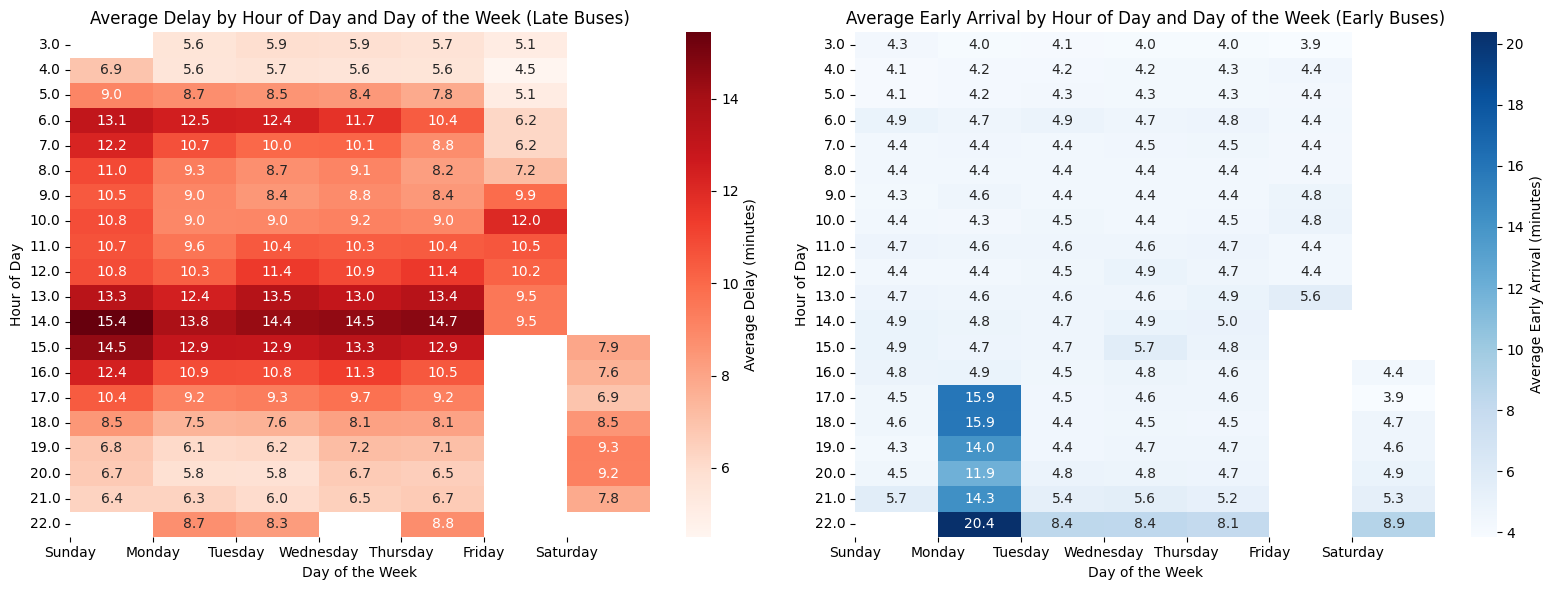

In [95]:
filtered_df = df[(df['total_trips'] >= 30000)]

plot_delays_heatmap(filtered_df)

#### What Was Filtered:
- We filtered out periods (specific hour/day combinations) where the total number of bus trips was below 30,000. This threshold was chosen based on the distribution of trips in the dataset, where lower trip counts could lead to unreliable averages.
- This resulted in the removal of rows where the sample size was too small, reducing the impact of extreme or anomalous delays that may not represent typical behavior.

#### Observations After Filtering:
- **Late Buses**: 
  - Previously, there were several extreme delays (e.g., very high delays during early morning hours on Saturday), which are no longer present after filtering. These extreme delays were likely due to low trip counts and have been removed for a more accurate representation.
  - The heatmap now shows a more consistent distribution of delays, with peaks around the middle of the day (particularly 13:00 to 15:00) across most weekdays.
  
- **Early Buses**: 
  - Similar to the late bus heatmap, early bus periods with extreme early arrivals (e.g., Monday night and Tuesday night) have been adjusted. The visual representation is now more uniform, showing clearer patterns of early arrivals between 16:00 and 21:00 on certain weekdays.

- **Shabbat (Friday & Saturday)**: 
  - Public transportation stops early on Fridays and is mostly unavailable on Saturdays due to religious observance. This explains the low trip counts during these days, especially on Friday afternoons and Saturday.

- **Late-Night & Early Morning**:
  - Between midnight and 5:00 AM, bus services are minimal, with only a few night lines operating, resulting in fewer trips during these hours.
- **Friday Evenings**:
  - Buses stop running early on Friday for Shabbat, leading to very few or no trips late Friday night.

### **Average Delay by Hour of Day and Day of the Week (Late Buses)**

#### **What is Important to Notice?**

1. **Sunday Midday to Early Afternoon Delays**:
   - The largest delays occur on **Sunday**, particularly between **12 PM and 2 PM**, where delays peak at **15.4 minutes** around **1 PM**. This is the highest delay recorded during the week, likely reflecting weekend traffic and the start of the workweek.

2. **Morning Delays Across the Week**:
   - Delays during the morning hours (6 AM to 9 AM) are moderate. The highest morning delays are on **Sunday**, reaching up to **13.1 minutes** at **6 AM**. This could reflect heavier traffic and demand as people begin their commutes. 
   - **Monday morning delays** are lower compared to Sunday but still significant, averaging between **9 and 12.5 minutes**.

3. **Evening Delays**:
   - Delays during evening hours (after **6 PM**) are relatively low throughout the week, consistently staying below **9 minutes**. The lowest delays are recorded on **Sunday evening** after **8 PM**, with delays dropping to around **6-7 minutes**.

4. **Weekend Delays**:
   - On **Saturday**, delays are relatively light throughout the day, with the highest delays occurring around **4-5 PM** at **9.3 minutes**, reflecting the reduced bus schedules and lighter traffic on weekends.

#### **Conclusions**:
- **Sunday afternoon** experiences the worst delays of the week, peaking between **12 PM and 2 PM**.
- **Sunday morning** also shows substantial delays, with significant congestion as the week begins.
- **Evenings** show consistently lower delays after **6 PM**, with most delays staying below **9 minutes**.


### **Average Early Arrival by Hour of Day and Day of the Week (Early Buses)**

#### **What is Important to Notice?**

1. **Monday Evening Anomalies**:
   - **Monday evenings** stand out with significant early arrivals. On **Monday at 10 PM**, buses arrive as much as **20.4 minutes early**, and between **6 PM and 7 PM**, buses arrive up to **15.9 minutes early**.

2. **Consistent Early Arrivals in the Morning**:
   - Across most days of the week, morning hours (between **6 AM and 9 AM**) show consistent early arrivals, with buses arriving **4-5 minutes early**. This consistency suggests stable operations during the morning commute.


#### **Conclusions**:
- **Monday evenings** present clear anomalies, with extreme early arrivals
- Early arrivals are more stable during **morning hours**, with buses arriving **4-5 minutes early** consistently.


### **Conclusions**:
- **Data Focus on Peak Hours**: Based on the filtered data, we will focus future analyses on peak working hours (5 AM to 10 PM) when bus trips are more consistent and representative. Late-night and early-morning periods tend to have fewer trips and more variability, which may skew the analysis.
- **Day and Hour Impact on Bus Delays**: The data clearly shows that day and hour significantly influence whether a bus will be late or early. For example, **Sunday afternoons** experience the worst delays (up to 15.4 minutes). These insights suggest that different operational strategies or rider demand patterns are at play during these periods.


In [ ]:
# queries to do overnight - 

# 1. update bus status column
query = """UPDATE processed_data
SET bus_status = CASE
    WHEN arrival_time_diff > 0 THEN 'late'
    WHEN arrival_time_diff < 0 THEN 'early'
    ELSE 'On-Time'
END;"""

# 2. insert feature "is_peak" to the processed_data table
query = """ALTER TABLE processed_data ADD COLUMN is_peak SMALLINT;
UPDATE processed_data
SET is_peak = CASE
    WHEN scheduled_arrival_time__hour BETWEEN 5 AND 9 THEN 1
    WHEN scheduled_arrival_time__hour BETWEEN 13 AND 18 THEN 1
    ELSE 0
END;
"""

# 3. insert feature "is_nighttime" to the processed_data table
query = """ALTER TABLE processed_data ADD COLUMN is_nighttime SMALLINT;
UPDATE processed_data
SET is_nighttime = CASE
    WHEN scheduled_arrival_time__hour BETWEEN 0 AND 4 THEN 1
    WHEN scheduled_arrival_time__hour BETWEEN 22 AND 23 THEN 1
    ELSE 0
END;
"""

# 4. insert feature "total_stop_frequency" to the processed_data table
query = """ALTER TABLE processed_data ADD COLUMN stop_frequency SMALLINT;
WITH stop_counts AS (
    SELECT gtfs_stop_code, COUNT(*) AS stop_frequency
    FROM processed_data
    GROUP BY gtfs_stop_code
)
UPDATE processed_data
SET stop_frequency = stop_counts.stop_frequency
FROM stop_counts
WHERE processed_data.gtfs_stop_code = stop_counts.gtfs_stop_code;
"""

# 5. insert feature "hourly_stop_frequency" to the processed_data table
query = """ALTER TABLE processed_data ADD COLUMN hourly_stop_frequency SMALLINT;
WITH hourly_stop_counts AS (
    SELECT scheduled_arrival_time__hour, gtfs_stop_code, COUNT(*) AS hourly_stop_frequency
    FROM processed_data
    GROUP BY scheduled_arrival_time__hour, gtfs_stop_code
)
UPDATE processed_data
SET hourly_stop_frequency = hourly_stop_counts.hourly_stop_frequency
FROM hourly_stop_counts
WHERE processed_data.scheduled_arrival_time__hour = hourly_stop_counts.scheduled_arrival_time__hour
"""

# 6. insert_feature "daily_stop_frequency" to the processed_data table
query = """ALTER TABLE processed_data ADD COLUMN daily_stop_frequency SMALLINT;
WITH daily_stop_counts AS (
    SELECT scheduled_arrival_time__day_of_week, gtfs_stop_code, COUNT(*) AS daily_stop_frequency
    FROM processed_data
    GROUP BY scheduled_arrival_time__day_of_week, gtfs_stop_code
)
UPDATE processed_data
SET daily_stop_frequency = daily_stop_counts.daily_stop_frequency
FROM daily_stop_counts
WHERE processed_data.scheduled_arrival_time__day_of_week = daily_stop_counts.scheduled_arrival_time__day_of_week
"""



In [ ]:
update_query = """
UPDATE processed_data
        SET 
            is_weekend = CASE
                WHEN scheduled_arrival_time__day_of_week IN (4, 5) THEN 1
                ELSE 0
            END,
            is_peak = CASE
                WHEN scheduled_arrival_time__hour BETWEEN 5 AND 9 OR scheduled_arrival_time__hour BETWEEN 13 AND 18 THEN 1
                ELSE 0
            END,
            is_nighttime = CASE
                WHEN scheduled_arrival_time__hour BETWEEN 0 AND 4 OR scheduled_arrival_time__hour BETWEEN 22 AND 23 THEN 1
                ELSE 0
            END,
            bus_status = CASE
			    WHEN arrival_time_diff > 0 THEN 'Late'
			    WHEN arrival_time_diff < 0 THEN 'Early'
		    	ELSE 'On-Time'
			END
"""
# data_processing.execute_query(update_query, engine)

data_processing.execute_query_parallel(update_query, 'processed_data', engine, 50000, 84951938) 

Query executed successfully.
Batch starting at offset 300000 executed in 31.87 seconds.
Query executed successfully.
Batch starting at offset 500000 executed in 32.16 seconds.
Query executed successfully.
Batch starting at offset 50000 executed in 33.31 seconds.
Query executed successfully.
Batch starting at offset 100000 executed in 35.46 seconds.
Query executed successfully.
Batch starting at offset 400000 executed in 35.97 seconds.
Query executed successfully.
Batch starting at offset 250000 executed in 36.16 seconds.
Query executed successfully.
Batch starting at offset 550000 executed in 36.22 seconds.
Query executed successfully.
Batch starting at offset 450000 executed in 36.54 seconds.
Query executed successfully.
Batch starting at offset 200000 executed in 37.48 seconds.
Query executed successfully.
Batch starting at offset 350000 executed in 37.74 seconds.
Query executed successfully.
Batch starting at offset 650000 executed in 37.86 seconds.
Query executed successfully.
Batc

In [ ]:
query = """SELECT is_weekend, bus_status, ROUND(AVG(adjusted_arrival_time_diff / (60 * 1e9)), 2) AS mean
FROM processed_data
GROUP BY is_weekend, bus_status
"""

df = pd.read_sql(query, engine)

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='avg_delay', data=weekend_delay_df)
plt.title('Average Bus Delay: Weekend vs. Weekday')
plt.ylabel('Average Delay (Minutes)')
plt.xlabel('Day Type')
plt.show()

# Model Training 

In [33]:
df = pd.read_sql('SELECT * FROM processed_data WHERE gtfs_route_mkt = \'14068\'', engine)


In [45]:
label_encoder = LabelEncoder()


print("Starting data preprocessing...")
df['arrival_time_diff'] = df['arrival_time_diff'] / 1e9
df['city_encoded'] = label_encoder.fit_transform(df['gtfs_stop_city'])
df['vehicle_encoded'] = label_encoder.fit_transform(df['siri_vehicle_ref'])
df['line_encoded'] = label_encoder.fit_transform(df['siri_line_ref'])
df['stop_code_encoded'] = label_encoder.fit_transform(df['siri_stop_code'])
df['siri_stop_order'] = df['siri_stop_order'].astype(int)
print("Data preprocessing completed.")

Starting data preprocessing...
Data preprocessing completed.


In [30]:
from sklearn.ensemble import RandomForestRegressor



# Select features and target
print("Selecting features and target...")
features = df[['siri_stop_order', 'distance_from_stop', 'stop_code_encoded', 'line_encoded',
               'vehicle_encoded', 
               'recorded_at_time__hour', 
               'recorded_at_time__day_of_week',
               'recorded_at_time__minute',
               'recorded_at_time__day_of_month',
               'city_encoded'
]]  # Example features
target = df['arrival_time_diff']
print("Features and target selected.")

# Split the data into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("Data split completed.")

# Initialize a regression model (Random Forest in this case)
print("Initializing the model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
print("Model initialized.")

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Model trained.")

# Make predictions on the test set
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions made.")

# Evaluate the model
print("Evaluating the model...")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print("Model evaluation completed.")

Selecting features and target...
Features and target selected.
Splitting data into train and test sets...
Data split completed.
Initializing the model...
Model initialized.
Training the model...
Model trained.
Making predictions...
Predictions made.
Evaluating the model...
Mean Absolute Error: 972.3563953973546
Root Mean Squared Error: 281027.96249086986
Model evaluation completed.


In [56]:
from statsmodels.tsa.stattools import adfuller

df.index = df['recorded_at_time']

# Select features and target
print("Selecting features and target...")
features = df[['siri_stop_order', 'distance_from_stop', 'stop_code_encoded', 'line_encoded',
               'vehicle_encoded',
               'city_encoded'
]]  # Example features
target = df['arrival_time_diff']
print("Features and target selected.")


# Split the data into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("Data split completed.")


Selecting features and target...
Features and target selected.
Splitting data into train and test sets...
Data split completed.


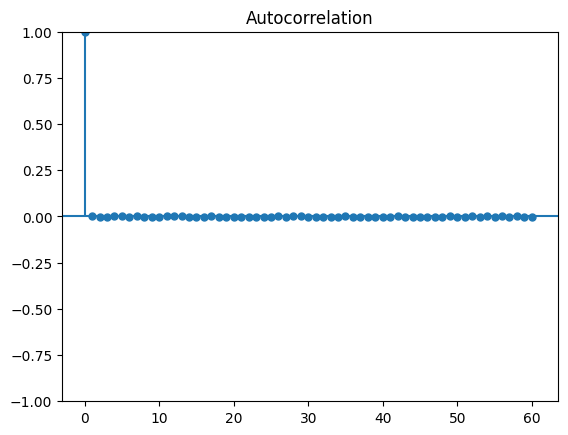

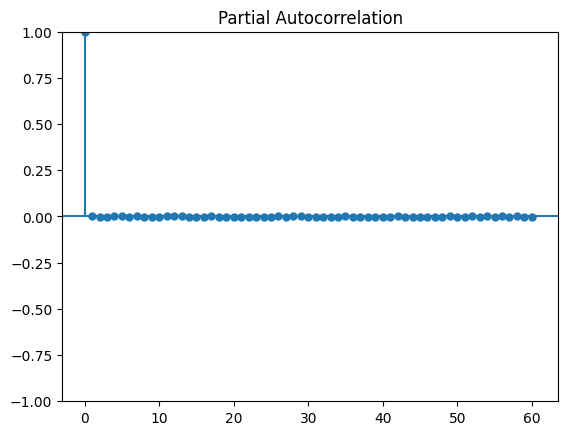

In [32]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_train)
plot_pacf(y_train)
plt.show()

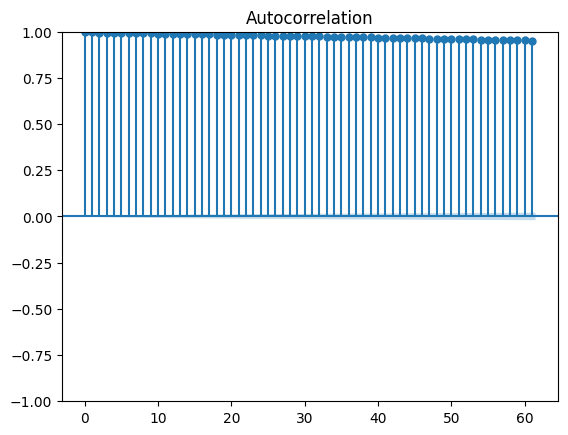

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['arrival_time_diff'])
plt.show()

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("Initializing the model...")
# Fit SARIMAX model
model = SARIMAX(y_train,
                 exog=X_train,
                 order=(1,0,1),  # specify ARIMA orders
                 seasonal_order=(1,0,0,24),  # specify seasonal orders
                 enforce_stationarity=False,
                 enforce_invertibility=False)
print("Model initialized.")

# Train the model
print("Training the model...")
model_fit = model.fit()
print("Model trained.")

# # Make predictions on the test set
# print("Making predictions...")
# predictions = results.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
# print("Predictions made.")

# # Evaluate the model
# print("Evaluating the model...")
# mae = mean_absolute_error(y_test, y_pred) / 1e9
# rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / 1e9
# print(f'Mean Absolute Error: {mae} seconds')
# print(f'Root Mean Squared Error: {rmse} seconds')
# print("Model evaluation completed.")

Initializing the model...


c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monoto

Model initialized.
Training the model...


c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 4.01 GiB for an array with shape (25, 25, 861729) and data type float64

In [55]:
print(type(X_test.index[0]))
print(X_test.index[0] in model_fit.data.orig_endog.index)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
False


In [54]:
# Make predictions on the test set
print("Making predictions...")
y_pred = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
print("Predictions made.")

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Convert errors from nanoseconds to seconds
mae = mae / 1e9
rmse = rmse / 1e9

print(f'Mean Absolute Error: {mae} seconds')
print(f'Root Mean Squared Error: {rmse} seconds')

Making predictions...


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# Evaluate the model
print("Evaluating the model...")
mae = mean_absolute_error(y_test, y_pred) / 1e9
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / 1e9
print(f'Mean Absolute Error: {mae} seconds')
print(f'Root Mean Squared Error: {rmse} seconds')
print("Model evaluation completed.")

## Preprocessing


In [60]:
df['arrival_time_diff']

recorded_at_time
2023-01-02 06:06:55+00:00   -2.863613e-07
2023-01-02 06:10:20+00:00   -8.687011e-09
2023-01-02 06:06:55+00:00   -3.796633e-07
2023-01-02 06:13:39+00:00   -9.744767e-09
2023-01-02 06:14:39+00:00   -1.436143e-08
                                 ...     
2023-03-22 03:46:07+00:00   -4.794571e-07
2023-03-22 03:47:04+00:00   -4.196343e-07
2023-03-22 03:47:47+00:00   -4.335177e-07
2023-03-22 03:48:53+00:00   -4.176719e-07
2023-03-22 03:50:06+00:00   -4.497326e-07
Name: arrival_time_diff, Length: 1077162, dtype: float64

In [23]:
bus_data = batch.copy()
label_encoder = LabelEncoder()
bus_data['siri_journey_ref'] = label_encoder.fit_transform(bus_data['siri_journey_ref'])
# Dropping string columns
bus_data.drop(columns=['gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True) 
# Dropping null data
bus_data.dropna(inplace=True)
# formatting time diff to sec from TimeDelta
bus_data['arrival_time_diff'] = bus_data['arrival_time_diff'].dt.total_seconds()

bus_data['city_encoded'] = label_encoder.fit_transform(bus_data['gtfs_stop_city'])

bus_data = pd.get_dummies(bus_data, columns=['bus_status'])
bus_data.drop(columns=['bus_status_num'], inplace=True)

time_columns = [col for col in bus_data.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    bus_data[col] = pd.to_datetime(bus_data[col])
    
    # Create new columns for month, day of month, hour and minute
    bus_data[col + '__month'] = bus_data[col].dt.month
    bus_data[col + '__day'] = bus_data[col].dt.day
    bus_data[col + '__day_of_week'] = bus_data[col].dt.dayofweek
    bus_data[col + '__hour'] = bus_data[col].dt.hour
    bus_data[col + '__minute'] = bus_data[col].dt.minute

bus_data.drop(columns=time_columns, inplace=True)

id_features = ['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_operator_ref', 'siri_line_ref']

other_features = ['gtfs_stop_sequence', 'siri_stop_order', 'gtfs_route_direction',
                   'closet_location_speed', 'closest_location_bearing', 'distance_from_stop',
                     'moving_towards_stop', 'city_encoded']
time_features = ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'recorded_at_time__day_of_month',
       'recorded_at_time__month', 'scheduled_arrival_time__month', 'scheduled_arrival_time__day',
       'scheduled_arrival_time__day_of_week', 'scheduled_arrival_time__hour',
       'scheduled_arrival_time__minute']

target_variables = ['bus_status_Early', 'bus_status_Late', 'bus_status_On Time', 'arrival_time_diff']
target_variables_time = ['estimated_arrival_time__month',
       'estimated_arrival_time__day', 'estimated_arrival_time__day_of_week',
       'estimated_arrival_time__hour', 'estimated_arrival_time__minute']

features = id_features + other_features + time_features 
target = target_variables + target_variables_time


NameError: name 'batch' is not defined

In [31]:
bus_data[features]

,id,siri_journey_ref,siri_vehicle_ref,siri_stop_code,siri_operator_ref,siri_line_ref,gtfs_stop_sequence,siri_stop_order,gtfs_route_direction,closet_location_speed,...,recorded_at_time__day_of_week,recorded_at_time__hour,recorded_at_time__minute,recorded_at_time__day_of_month,recorded_at_time__month,scheduled_arrival_time__month,scheduled_arrival_time__day,scheduled_arrival_time__day_of_week,scheduled_arrival_time__hour,scheduled_arrival_time__minute
0,1473611409,0,7728469,2524,3,12390,1,1,2,2.474103e+06,...,3,12,26,5,1,1,5,3,12,3
17,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
18,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
19,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
20,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429073,1473908971,2326,7728669,5985,3,11108,33,33,2,6.744721e+01,...,3,12,55,5,1,1,5,3,12,41
429074,1473914652,2326,7728669,2811,3,11108,34,34,2,1.018009e+02,...,3,12,56,5,1,1,5,3,12,42
429075,1473920304,2326,7728669,109,3,11108,35,35,2,6.962211e+01,...,3,12,57,5,1,1,5,3,12,43
429076,1473925951,2326,7728669,112,3,11108,36,36,2,6.842899e+01,...,3,12,58,5,1,1,5,3,12,43


In [29]:
import category_encoders as ce

X = bus_data[features]
y = bus_data[target]

# Binary encode categorical features
encoder = ce.BinaryEncoder(cols=id_features)
X_encoded = encoder.fit_transform(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('after scaler')

# Define RNN model
model = Sequential([
    LSTM(units=64, input_shape=(X_train_scaled.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(target), activation='linear')
])

print('after model')

# Compile model
model.compile(optimizer='adam', loss='mse')

print('after compile')

# Reshape input data for LSTM layer
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

print('after fit')

# Evaluate model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

NameError: name 'bus_data' is not defined

In [174]:
label_encoder = LabelEncoder()
batch['siri_journey_ref'] = label_encoder.fit_transform(batch['siri_journey_ref'])
batch.drop(columns=['gtfs_stop_city', 'gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True)
batch.dropna(subset=['scheduled_arrival_time'], inplace=True)
batch['arrival_time_diff'] = batch['arrival_time_diff'].dt.total_seconds()


time_columns = [col for col in batch.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    batch[col] = pd.to_datetime(batch[col])
    
    # Create new columns for month, day of month, hour and minute
    batch[col + '_month'] = batch[col].dt.month
    batch[col + '_day'] = batch[col].dt.day
    batch[col + '_hour'] = batch[col].dt.hour
    batch[col + '_minute'] = batch[col].dt.minute

batch.drop(columns=time_columns, inplace=True)



In [175]:
batch.dropna(inplace=True)

target_variables = ['estimated_arrival_time_month', 'estimated_arrival_time_day', 'estimated_arrival_time_hour', 'estimated_arrival_time_minute', 'arrival_time_diff', 'bus_status_Early', 'bus_status_Late',
       'bus_status_Missing', 'bus_status_On Time', 'bus_status_num']

# Define features (X) and target variable (y)
X = batch.drop(columns=target_variables, axis=1)  # Features
y = batch[target_variables]  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Print the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (447810, 34) (447810, 10)
Testing set shape: (298540, 34) (298540, 10)


In [1]:
batch.head()

NameError: name 'batch' is not defined

In [180]:
X_train.columns
# print(X_test.isnull().sum())



Index(['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code',
       'siri_stop_order', 'siri_operator_ref', 'siri_line_ref',
       'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon',
       'gtfs_stop_sequence', 'gtfs_route_direction', 'gtfs_route_mkt',
       'closest_location', 'closest_location_lat', 'closest_location_lon',
       'closet_location_speed', 'closest_location_bearing',
       'distance_from_stop', 'moving_towards_stop',
       'gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'day_of_month', 'month', 'city_encoded',
       'scheduled_arrival_time_month', 'scheduled_arrival_time_day',
       'scheduled_arrival_time_hour', 'scheduled_arrival_time_minute'],
      dtype='object')

In [176]:
# Initialize the scaler
scaler = StandardScaler()


# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Access the coefficients of the linear regression model
coefficients = model.coef_
print(coefficients)
coefficients_flat = coefficients.flatten()

# Create a DataFrame to display the coefficients with their corresponding feature names
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients_flat})
print(feature_importance)

In [178]:
y_pred = model.predict(X_test_scaled)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)



In [35]:
import pandas as pd
from sqlalchemy import create_engine

# Read the Parquet file
df = pd.read_parquet('2023_siri_data/concatenated_data_parquet/output_1_from_2023-01-01.00_at_0_to_2023-01-03.05_at_69983.parquet')

# Create the connection string
database_username = 'postgres'
database_password = 'postgres'
database_ip       = 'localhost'
database_name     = 'siri_2023'
database_connection = f'postgresql://{database_username}:{database_password}@{database_ip}/{database_name}'

# Create SQLAlchemy engine
engine = create_engine(database_connection)

# Insert the dataframe into the PostgreSQL table
df.to_sql('processed_data', engine, if_exists='append', index=False)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)